In [2]:
# =========================================================
# PROYECTO INTEGRADOR: FASHION-MNIST CNN + AUTOENCODER
# Aplicando mejores prácticas de SIC_AI_Ch8
# =========================================================

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Input, UpSampling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Configuración de reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU disponible: []


In [3]:
# =========================================================
# 1. CONFIGURACIÓN Y CARGA DE DATOS
# =========================================================

class FashionMNISTDataPreparer:
    """
    Clase para manejar la carga y preparación de datos Fashion-MNIST
    siguiendo las mejores prácticas de SIC_AI_Ch8
    """

    def __init__(self):
        self.class_names = [
            'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
        ]
        self.scaler = MinMaxScaler()

    def load_and_preprocess_data(self):
        """
        Carga y preprocesa los datos siguiendo el patrón de SIC_AI_Ch8
        """
        print("=== CARGANDO FASHION-MNIST DATASET ===")

        # Cargar datos usando tensorflow_datasets
        (ds_train, ds_test), ds_info = tfds.load(
            'fashion_mnist',
            split=['train', 'test'],
            shuffle_files=True,
            as_supervised=True,
            with_info=True
        )

        print(f"Dataset info: {ds_info}")
        print(f"Clases: {len(self.class_names)}")

        # Convertir a numpy arrays para facilitar manipulación
        X_train, y_train = [], []
        X_test, y_test = [], []

        # Procesar training set
        for image, label in ds_train:
            X_train.append(image.numpy())
            y_train.append(label.numpy())

        # Procesar test set
        for image, label in ds_test:
            X_test.append(image.numpy())
            y_test.append(label.numpy())

        X_train = np.array(X_train)
        y_train = np.array(y_train)
        X_test = np.array(X_test)
        y_test = np.array(y_test)

        print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
        print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")

        # Normalización siguiendo SIC_AI_Ch8
        X_train = X_train.astype('float32') / 255.0
        X_test = X_test.astype('float32') / 255.0

        # Reshape para CNN (añadir canal)
        X_train = X_train.reshape(-1, 28, 28, 1)
        X_test = X_test.reshape(-1, 28, 28, 1)

        # Crear validation set siguiendo SIC_AI_Ch8
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
        )

        print(f"Final shapes:")
        print(f"  Train: X={X_train.shape}, y={y_train.shape}")
        print(f"  Validation: X={X_val.shape}, y={y_val.shape}")
        print(f"  Test: X={X_test.shape}, y={y_test.shape}")

        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

    def simulate_class_imbalance(self, X_train, y_train, minority_class=5, keep_ratio=0.1):
        """
        Simula desbalance de clases reduciendo una clase específica
        """
        print(f"\n=== SIMULANDO DESBALANCE EN CLASE {minority_class} ({self.class_names[minority_class]}) ===")

        # Encontrar índices de la clase minoritaria
        minority_indices = np.where(y_train == minority_class)[0]
        other_indices = np.where(y_train != minority_class)[0]

        # Mantener solo un porcentaje de la clase minoritaria
        keep_count = int(len(minority_indices) * keep_ratio)
        kept_minority = np.random.choice(minority_indices, keep_count, replace=False)

        # Combinar índices
        final_indices = np.concatenate([other_indices, kept_minority])
        np.random.shuffle(final_indices)

        X_train_imbalanced = X_train[final_indices]
        y_train_imbalanced = y_train[final_indices]

        # Mostrar distribución
        unique, counts = np.unique(y_train_imbalanced, return_counts=True)
        print("Distribución después del desbalance:")
        for i, (cls, count) in enumerate(zip(unique, counts)):
            print(f"  Clase {cls} ({self.class_names[cls]}): {count} muestras")

        return X_train_imbalanced, y_train_imbalanced

    def visualize_samples(self, X, y, n_samples=10):
        """
        Visualiza muestras del dataset
        """
        fig, axes = plt.subplots(2, 5, figsize=(12, 6))
        axes = axes.ravel()

        for i in range(n_samples):
            idx = np.random.randint(0, len(X))
            image = X[idx].squeeze()
            label = y[idx]

            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(f'{self.class_names[label]}')
            axes[i].axis('off')

        plt.suptitle('Muestras del Dataset Fashion-MNIST')
        plt.tight_layout()
        plt.show()

In [4]:
# =========================================================
# 2. MODELOS CNN Y AUTOENCODER (MEJORADOS CON SIC_AI_Ch8)
# =========================================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout, Input, Cropping2D

class FashionMNISTCNN:
    """
    CNN mejorada siguiendo arquitectura de SIC_AI_Ch8
    """

    def __init__(self, input_shape=(28, 28, 1), num_classes=10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None

    def build_model(self):
        """
        Construye CNN siguiendo patrones de SIC_AI_Ch8
        """
        print("=== CONSTRUYENDO CNN MODEL ===")

        model = Sequential()

        # Primera capa convolucional (siguiendo patrón SIC_AI_Ch8)
        model.add(Conv2D(
            filters=32,
            kernel_size=(5, 5),
            padding='same',
            activation='relu',
            input_shape=self.input_shape
        ))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Segunda capa convolucional
        model.add(Conv2D(
            filters=64,
            kernel_size=(5, 5),
            padding='same',
            activation='relu'
        ))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Tercera capa convolucional (mejora respecto al original)
        model.add(Conv2D(
            filters=128,
            kernel_size=(3, 3),
            padding='same',
            activation='relu'
        ))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Aplanar
        model.add(Flatten())

        # Capas densas con Dropout (siguiendo SIC_AI_Ch8)
        model.add(Dense(units=1024, activation='relu'))
        model.add(Dropout(rate=0.5))

        model.add(Dense(units=512, activation='relu'))
        model.add(Dropout(rate=0.3))

        # Capa de salida
        model.add(Dense(units=self.num_classes, activation='softmax'))

        self.model = model
        return model

    def compile_model(self, learning_rate=0.001):
        """
        Compila el modelo siguiendo configuración de SIC_AI_Ch8
        """
        if self.model is None:
            raise ValueError("Model must be built first")

        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        print("Modelo CNN compilado exitosamente")
        self.model.summary()

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=200):
        """
        Entrena el modelo con callbacks mejorados
        """
        print("\n=== ENTRENANDO CNN ===")

        # Callbacks siguiendo mejores prácticas
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),
            ModelCheckpoint(
                'best_cnn_model.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        return history

class FashionMNISTAutoencoder:
    """
    Autoencoder mejorado para control de calidad
    """

    def __init__(self, input_shape=(28, 28, 1)):
        self.input_shape = input_shape
        self.model = None

    def build_model(self):
        """
        Construye autoencoder convolucional
        """
        print("=== CONSTRUYENDO AUTOENCODER ===")

        # Encoder
        inputs = Input(shape=self.input_shape)

        # Encoder layers (siguiendo patrón de SIC_AI_Ch8)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        x = MaxPooling2D((2, 2), padding='same')(x)

        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        # Decoder layers
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)  # 4x4 → 8x8

        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)  # 8x8 → 16x16

        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)  # 16x16 → 32x32
        x = Cropping2D(cropping=((2, 2), (2, 2)))(x)  # 32x32 → 28x28

        # Output layer (solo una vez)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        # Create model
        self.model = Model(inputs, decoded)
        return self.model

    def compile_model(self, learning_rate=0.001):
        """
        Compila el autoencoder
        """
        if self.model is None:
            raise ValueError("Model must be built first")

        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['mae']
        )

        print("Autoencoder compilado exitosamente")
        self.model.summary()

    def prepare_normal_class_data(self, X, y, normal_class=0):
        """
        Prepara datos de una clase específica para entrenar el autoencoder
        """
        normal_indices = np.where(y == normal_class)[0]
        X_normal = X[normal_indices]

        print(f"Clase normal seleccionada: {normal_class}")
        print(f"Muestras de clase normal: {len(X_normal)}")

        return X_normal

    def train(self, X_normal, epochs=100, batch_size=32, validation_split=0.2):
        """
        Entrena el autoencoder con la clase normal
        """
        print(f"\n=== ENTRENANDO AUTOENCODER CON CLASE NORMAL ===")

        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.3,
                patience=7,
                min_lr=1e-7,
                verbose=1
            )
        ]

        history = self.model.fit(
            X_normal, X_normal,  # Input = Target para autoencoder
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=callbacks,
            verbose=1
        )

        return history

    def calculate_reconstruction_error(self, X):
        """
        Calcula el error de reconstrucción
        """
        reconstructed = self.model.predict(X, verbose=0)
        mse_errors = np.mean(np.square(X - reconstructed), axis=(1, 2, 3))
        return mse_errors

In [5]:
# =========================================================
# 3. PIPELINE DE EVALUACIÓN MEJORADO
# =========================================================

class ModelEvaluator:
    """
    Clase para evaluación completa de modelos
    """

    def __init__(self, class_names):
        self.class_names = class_names

    def evaluate_cnn(self, cnn_model, X_test, y_test):
        """
        Evaluación completa de CNN siguiendo SIC_AI_Ch8
        """
        print("\n=== EVALUACIÓN CNN ===")

        # Predicciones
        y_pred_prob = cnn_model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_pred_prob, axis=1)

        # Métricas básicas
        test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.title('Matriz de Confusión - CNN')
        plt.xlabel('Predicción')
        plt.ylabel('Etiqueta Real')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Reporte de clasificación
        print("\n=== REPORTE DE CLASIFICACIÓN ===")
        print(classification_report(y_test, y_pred, target_names=self.class_names))

        # Accuracy por clase
        class_accuracies = cm.diagonal() / cm.sum(axis=1)
        print("\n=== ACCURACY POR CLASE ===")
        for i, acc in enumerate(class_accuracies):
            print(f"{self.class_names[i]}: {acc:.4f}")

        return {
            'accuracy': test_accuracy,
            'loss': test_loss,
            'predictions': y_pred,
            'probabilities': y_pred_prob,
            'confusion_matrix': cm,
            'class_accuracies': class_accuracies
        }

    def evaluate_autoencoder(self, autoencoder_model, X_test, y_test, normal_class=0):
        """
        Evaluación del autoencoder para detección de anomalías
        """
        print("\n=== EVALUACIÓN AUTOENCODER ===")

        # Calcular errores de reconstrucción
        reconstruction_errors = autoencoder_model.calculate_reconstruction_error(X_test)

        # Crear etiquetas binarias (normal vs anómalo)
        y_binary = (y_test == normal_class).astype(int)

        # Calcular AUC
        try:
            # Para AUC, menor error = mayor probabilidad de ser normal
            auc_score = roc_auc_score(y_binary, -reconstruction_errors)
            print(f"AUC Score: {auc_score:.4f}")
        except ValueError as e:
            print(f"Error calculando AUC: {e}")
            auc_score = 0.0

        # Visualizar distribución de errores
        plt.figure(figsize=(15, 5))

        # Subplot 1: Histograma por clase
        plt.subplot(1, 3, 1)
        for class_id in np.unique(y_test):
            class_errors = reconstruction_errors[y_test == class_id]
            label = f"{self.class_names[class_id]}"
            if class_id == normal_class:
                label += " (Normal)"
            plt.hist(class_errors, bins=30, alpha=0.6, label=label)

        plt.xlabel('Error de Reconstrucción')
        plt.ylabel('Frecuencia')
        plt.title('Distribución de Errores por Clase')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Subplot 2: Boxplot por clase
        plt.subplot(1, 3, 2)
        error_data = []
        class_labels = []
        for class_id in np.unique(y_test):
            class_errors = reconstruction_errors[y_test == class_id]
            error_data.append(class_errors)
            label = f"C{class_id}"
            if class_id == normal_class:
                label += "*"
            class_labels.append(label)

        plt.boxplot(error_data, labels=class_labels)
        plt.xlabel('Clase (* = Normal)')
        plt.ylabel('Error de Reconstrucción')
        plt.title('Boxplot de Errores por Clase')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)

        # Subplot 3: ROC Curve
        plt.subplot(1, 3, 3)
        try:
            fpr, tpr, _ = roc_curve(y_binary, -reconstruction_errors)
            plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
            plt.plot([0, 1], [0, 1], 'k--', label='Random')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve - Detección de Anomalías')
            plt.legend()
            plt.grid(True, alpha=0.3)
        except:
            plt.text(0.5, 0.5, 'Error en ROC', ha='center', va='center')

        plt.tight_layout()
        plt.show()

        # Estadísticas por clase
        print("\n=== ESTADÍSTICAS DE ERROR POR CLASE ===")
        for class_id in np.unique(y_test):
            class_errors = reconstruction_errors[y_test == class_id]
            print(f"{self.class_names[class_id]}:")
            print(f"  Media: {np.mean(class_errors):.6f}")
            print(f"  Std: {np.std(class_errors):.6f}")
            print(f"  Min: {np.min(class_errors):.6f}")
            print(f"  Max: {np.max(class_errors):.6f}")

        return {
            'auc_score': auc_score,
            'reconstruction_errors': reconstruction_errors,
            'binary_labels': y_binary
        }

In [6]:
# =========================================================
# 4. SISTEMA DE DECISIÓN EN PRODUCCIÓN
# =========================================================

class ProductionDecisionSystem:
    """
    Sistema de decisión que combina CNN y Autoencoder
    """

    def __init__(self, cnn_model, autoencoder_model, class_names,
                 confidence_threshold=0.8, reconstruction_threshold=0.01):
        self.cnn_model = cnn_model
        self.autoencoder_model = autoencoder_model
        self.class_names = class_names
        self.confidence_threshold = confidence_threshold
        self.reconstruction_threshold = reconstruction_threshold

    def predict_with_quality_check(self, X):
        """
        Predicción con verificación de calidad
        """
        # Predicción CNN
        predictions_prob = self.cnn_model.predict(X, verbose=0)
        predictions = np.argmax(predictions_prob, axis=1)
        max_confidences = np.max(predictions_prob, axis=1)

        # Error de reconstrucción
        reconstruction_errors = self.autoencoder_model.calculate_reconstruction_error(X)

        # Decisiones
        decisions = []
        for i in range(len(X)):
            confidence = max_confidences[i]
            error = reconstruction_errors[i]
            pred_class = predictions[i]

            # Lógica de decisión
            if confidence >= self.confidence_threshold and error <= self.reconstruction_threshold:
                decision = "ACCEPT"
            elif confidence < self.confidence_threshold:
                decision = "REJECT_LOW_CONFIDENCE"
            elif error > self.reconstruction_threshold:
                decision = "REJECT_QUALITY"
            else:
                decision = "REVIEW"

            decisions.append({
                'prediction': pred_class,
                'class_name': self.class_names[pred_class],
                'confidence': confidence,
                'reconstruction_error': error,
                'decision': decision
            })

        return decisions

    def get_production_metrics(self, decisions):
        """
        Calcula métricas de producción
        """
        total = len(decisions)

        accept_count = sum(1 for d in decisions if d['decision'] == 'ACCEPT')
        reject_conf_count = sum(1 for d in decisions if d['decision'] == 'REJECT_LOW_CONFIDENCE')
        reject_quality_count = sum(1 for d in decisions if d['decision'] == 'REJECT_QUALITY')
        review_count = sum(1 for d in decisions if d['decision'] == 'REVIEW')

        confidences = [d['confidence'] for d in decisions]
        errors = [d['reconstruction_error'] for d in decisions]

        metrics = {
            'total_samples': total,
            'accept_rate': accept_count / total,
            'reject_confidence_rate': reject_conf_count / total,
            'reject_quality_rate': reject_quality_count / total,
            'review_rate': review_count / total,
            'mean_confidence': np.mean(confidences),
            'p10_confidence': np.percentile(confidences, 10),
            'mean_reconstruction_error': np.mean(errors),
            'p95_reconstruction_error': np.percentile(errors, 95)
        }

        return metrics

In [7]:
# =========================================================
# 5. VISUALIZACIÓN DE RESULTADOS
# =========================================================

def plot_training_history(history, title="Training History"):
    """
    Visualiza el historial de entrenamiento (mejorado de SIC_AI_Ch8)
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    if 'accuracy' in history.history:
        axes[0].plot(history.history['accuracy'], 'b-', label='Train Accuracy', linewidth=2)
        if 'val_accuracy' in history.history:
            axes[0].plot(history.history['val_accuracy'], 'r-', label='Val Accuracy', linewidth=2)
        axes[0].set_title(f'{title} - Accuracy')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Accuracy')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(history.history['loss'], 'b-', label='Train Loss', linewidth=2)
    if 'val_loss' in history.history:
        axes[1].plot(history.history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[1].set_title(f'{title} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualize_reconstruction_samples(autoencoder, X_test, y_test, class_names, n_samples=10):
    """
    Visualiza muestras originales vs reconstruidas
    """
    fig, axes = plt.subplots(3, n_samples, figsize=(20, 6))

    # Seleccionar muestras aleatorias
    indices = np.random.choice(len(X_test), n_samples, replace=False)

    X_samples = X_test[indices]
    y_samples = y_test[indices]
    X_reconstructed = autoencoder.model.predict(X_samples, verbose=0)

    for i in range(n_samples):
        # Original
        axes[0, i].imshow(X_samples[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f'Original\n{class_names[y_samples[i]]}')
        axes[0, i].axis('off')

        # Reconstruida
        axes[1, i].imshow(X_reconstructed[i].squeeze(), cmap='gray')
        axes[1, i].set_title('Reconstruida')
        axes[1, i].axis('off')

        # Diferencia
        diff = np.abs(X_samples[i] - X_reconstructed[i])
        axes[2, i].imshow(diff.squeeze(), cmap='hot')
        error = np.mean(np.square(X_samples[i] - X_reconstructed[i]))
        axes[2, i].set_title(f'Diferencia\nMSE: {error:.6f}')
        axes[2, i].axis('off')

    plt.suptitle('Comparación Original vs Reconstruida', fontsize=16)
    plt.tight_layout()
    plt.show()

In [8]:
# =========================================================
# 6. PIPELINE PRINCIPAL EJECUTABLE
# =========================================================

def main_pipeline():
    """
    Pipeline principal mejorado siguiendo SIC_AI_Ch8
    """
    print("="*80)
    print("PROYECTO FASHION-MNIST: CNN + AUTOENCODER PIPELINE")
    print("Aplicando mejores prácticas de SIC_AI_Ch8")
    print("="*80)

    # 1. Preparación de datos
    data_preparer = FashionMNISTDataPreparer()
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = data_preparer.load_and_preprocess_data()

    # Visualizar muestras
    data_preparer.visualize_samples(X_test, y_test)

    # Simular desbalance
    X_train_imb, y_train_imb = data_preparer.simulate_class_imbalance(
        X_train, y_train, minority_class=5, keep_ratio=0.1
    )

    # 2. Construcción y entrenamiento de CNN
    print("\n" + "="*60)
    print("FASE 1: CNN PARA CLASIFICACIÓN")
    print("="*60)

    cnn = FashionMNISTCNN()
    cnn.build_model()
    cnn.compile_model(learning_rate=0.001)

    # Entrenamiento CNN
    history_cnn = cnn.train(
        X_train_imb, y_train_imb, X_val, y_val,
        epochs=30, batch_size=200
    )

    plot_training_history(history_cnn, "CNN Classification")

    # 3. Construcción y entrenamiento de Autoencoder
    print("\n" + "="*60)
    print("FASE 2: AUTOENCODER PARA CONTROL DE CALIDAD")
    print("="*60)

    autoencoder = FashionMNISTAutoencoder()
    autoencoder.build_model()
    autoencoder.compile_model(learning_rate=0.0002)

    # Preparar datos de clase normal (clase 0 - T-shirt/top)
    normal_class = 0
    X_normal = autoencoder.prepare_normal_class_data(X_train, y_train, normal_class)

    # Entrenamiento Autoencoder
    history_ae = autoencoder.train(
        X_normal, epochs=50, batch_size=32, validation_split=0.2
    )

    plot_training_history(history_ae, f"Autoencoder (Clase Normal: {data_preparer.class_names[normal_class]})")

    # 4. Evaluación de modelos
    print("\n" + "="*60)
    print("FASE 3: EVALUACIÓN DE MODELOS")
    print("="*60)

    evaluator = ModelEvaluator(data_preparer.class_names)

    # Evaluación CNN
    cnn_results = evaluator.evaluate_cnn(cnn.model, X_test, y_test)

    # Evaluación Autoencoder
    ae_results = evaluator.evaluate_autoencoder(autoencoder, X_test, y_test, normal_class)

    # Visualizar reconstrucciones
    visualize_reconstruction_samples(autoencoder, X_test, y_test, data_preparer.class_names, n_samples=8)

    # 5. Sistema de decisión en producción
    print("\n" + "="*60)
    print("FASE 4: SISTEMA DE DECISIÓN EN PRODUCCIÓN")
    print("="*60)

    # Configurar umbrales basados en resultados
    confidence_threshold = 0.85
    reconstruction_threshold = np.percentile(ae_results['reconstruction_errors'][y_test == normal_class], 95)

    print(f"Umbral de confianza: {confidence_threshold}")
    print(f"Umbral de reconstrucción: {reconstruction_threshold:.6f}")

    # Crear sistema de decisión
    decision_system = ProductionDecisionSystem(
        cnn.model, autoencoder, data_preparer.class_names,
        confidence_threshold=confidence_threshold,
        reconstruction_threshold=reconstruction_threshold
    )

    # Hacer predicciones en conjunto de test
    decisions = decision_system.predict_with_quality_check(X_test)

    # Calcular métricas de producción
    prod_metrics = decision_system.get_production_metrics(decisions)

    print("\n=== MÉTRICAS DE PRODUCCIÓN ===")
    print(f"Total de muestras: {prod_metrics['total_samples']}")
    print(f"Tasa de aceptación: {prod_metrics['accept_rate']:.3f}")
    print(f"Rechazos por baja confianza: {prod_metrics['reject_confidence_rate']:.3f}")
    print(f"Rechazos por calidad: {prod_metrics['reject_quality_rate']:.3f}")
    print(f"Para revisión: {prod_metrics['review_rate']:.3f}")
    print(f"Confianza media: {prod_metrics['mean_confidence']:.3f}")
    print(f"Confianza P10: {prod_metrics['p10_confidence']:.3f}")
    print(f"Error reconstrucción medio: {prod_metrics['mean_reconstruction_error']:.6f}")
    print(f"Error reconstrucción P95: {prod_metrics['p95_reconstruction_error']:.6f}")

    # 6. Visualización de decisiones de producción
    visualize_production_decisions(decisions, prod_metrics, data_preparer.class_names)

    # 7. Análisis de drift y monitoreo
    print("\n" + "="*60)
    print("FASE 5: SIMULACIÓN DE MONITOREO EN PRODUCCIÓN")
    print("="*60)

    monitor_results = simulate_production_monitoring(
        decision_system, X_test, y_test, data_preparer.class_names
    )

    # 8. Resumen final
    print("\n" + "="*80)
    print("RESUMEN FINAL DEL PROYECTO")
    print("="*80)

    print(f"\n🎯 RESULTADOS CNN:")
    print(f"   - Accuracy en test: {cnn_results['accuracy']:.4f}")
    print(f"   - Loss en test: {cnn_results['loss']:.4f}")
    print(f"   - Clase con mejor accuracy: {data_preparer.class_names[np.argmax(cnn_results['class_accuracies'])]}")
    print(f"   - Clase con peor accuracy: {data_preparer.class_names[np.argmin(cnn_results['class_accuracies'])]}")

    print(f"\n🔍 RESULTADOS AUTOENCODER:")
    print(f"   - AUC Score: {ae_results['auc_score']:.4f}")
    print(f"   - Clase normal utilizada: {data_preparer.class_names[normal_class]}")

    print(f"\n🏭 MÉTRICAS DE PRODUCCIÓN:")
    print(f"   - Tasa de aceptación: {prod_metrics['accept_rate']*100:.1f}%")
    print(f"   - Calidad del sistema: {(1-prod_metrics['reject_quality_rate'])*100:.1f}%")

    # Guardar modelos
    print(f"\n💾 GUARDANDO MODELOS...")
    cnn.model.save('fashion_mnist_cnn_final.h5')
    autoencoder.model.save('fashion_mnist_autoencoder_final.h5')
    print("   - fashion_mnist_cnn_final.h5")
    print("   - fashion_mnist_autoencoder_final.h5")

    return {
        'cnn_model': cnn.model,
        'autoencoder_model': autoencoder.model,
        'cnn_results': cnn_results,
        'ae_results': ae_results,
        'production_metrics': prod_metrics,
        'monitoring_results': monitor_results,
        'data_preparer': data_preparer
    }

def visualize_production_decisions(decisions, metrics, class_names):
    """
    Visualiza las decisiones del sistema de producción
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Distribución de decisiones
    decision_counts = {}
    for d in decisions:
        dec = d['decision']
        decision_counts[dec] = decision_counts.get(dec, 0) + 1

    axes[0, 0].bar(decision_counts.keys(), decision_counts.values(), color=['green', 'orange', 'red', 'blue'])
    axes[0, 0].set_title('Distribución de Decisiones')
    axes[0, 0].set_ylabel('Cantidad')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # 2. Distribución de confianza por decisión
    conf_by_decision = {}
    for d in decisions:
        dec = d['decision']
        if dec not in conf_by_decision:
            conf_by_decision[dec] = []
        conf_by_decision[dec].append(d['confidence'])

    axes[0, 1].boxplot([conf_by_decision.get(dec, [0]) for dec in decision_counts.keys()],
                       labels=decision_counts.keys())
    axes[0, 1].set_title('Confianza por Tipo de Decisión')
    axes[0, 1].set_ylabel('Confianza')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Error de reconstrucción por decisión
    error_by_decision = {}
    for d in decisions:
        dec = d['decision']
        if dec not in error_by_decision:
            error_by_decision[dec] = []
        error_by_decision[dec].append(d['reconstruction_error'])

    axes[1, 0].boxplot([error_by_decision.get(dec, [0]) for dec in decision_counts.keys()],
                       labels=decision_counts.keys())
    axes[1, 0].set_title('Error de Reconstrucción por Decisión')
    axes[1, 0].set_ylabel('Error MSE')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Predicciones por clase (solo aceptadas)
    accepted_preds = [d['prediction'] for d in decisions if d['decision'] == 'ACCEPT']
    if accepted_preds:
        unique_preds, pred_counts = np.unique(accepted_preds, return_counts=True)
        class_labels = [class_names[i] for i in unique_preds]
        axes[1, 1].bar(range(len(unique_preds)), pred_counts)
        axes[1, 1].set_xticks(range(len(unique_preds)))
        axes[1, 1].set_xticklabels(class_labels, rotation=45)
        axes[1, 1].set_title('Distribución de Predicciones Aceptadas')
        axes[1, 1].set_ylabel('Cantidad')

    plt.tight_layout()
    plt.show()

def simulate_production_monitoring(decision_system, X_test, y_test, class_names):
    """
    Simula monitoreo en producción con análisis de drift
    """
    print("\n=== SIMULANDO MONITOREO EN PRODUCCIÓN ===")

    # Simular batches de producción
    batch_size = 1000
    n_batches = len(X_test) // batch_size

    monitoring_results = {
        'batch_metrics': [],
        'drift_detected': False,
        'performance_degradation': False
    }

    print(f"Analizando {n_batches} batches de {batch_size} muestras cada uno...")

    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size

        X_batch = X_test[start_idx:end_idx]
        y_batch = y_test[start_idx:end_idx]

        # Obtener decisiones para este batch
        batch_decisions = decision_system.predict_with_quality_check(X_batch)
        batch_prod_metrics = decision_system.get_production_metrics(batch_decisions)

        # Simular latencia (en ms)
        import time
        start_time = time.time()
        # Simular procesamiento
        time.sleep(0.001)  # 1ms simulado
        end_time = time.time()
        latency_ms = (end_time - start_time) * 1000

        # Calcular métricas del batch
        confidences = [d['confidence'] for d in batch_decisions]
        errors = [d['reconstruction_error'] for d in batch_decisions]

        batch_metrics = {
            'batch_id': batch_idx,
            'timestamp': time.time(),
            'latency_mean_ms': latency_ms + np.random.normal(50, 10),  # Simular latencia realista
            'latency_p95_ms': latency_ms + np.random.normal(80, 15),
            'confidence_mean': np.mean(confidences),
            'confidence_p10': np.percentile(confidences, 10),
            'reconstruction_error_mean': np.mean(errors),
            'reconstruction_error_p95': np.percentile(errors, 95),
            'accept_rate': batch_prod_metrics['accept_rate'],
            'reject_quality_rate': batch_prod_metrics['reject_quality_rate']
        }

        monitoring_results['batch_metrics'].append(batch_metrics)

        # Detección de drift simple
        if batch_metrics['confidence_mean'] < 0.7:
            monitoring_results['drift_detected'] = True

        if batch_metrics['accept_rate'] < 0.5:
            monitoring_results['performance_degradation'] = True

    # Visualizar métricas de monitoreo
    visualize_monitoring_metrics(monitoring_results)

    return monitoring_results

def visualize_monitoring_metrics(monitoring_results):
    """
    Visualiza métricas de monitoreo en tiempo real
    """
    metrics_df = pd.DataFrame(monitoring_results['batch_metrics'])

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # 1. Latencia a lo largo del tiempo
    axes[0, 0].plot(metrics_df['batch_id'], metrics_df['latency_mean_ms'], 'b-', label='Media')
    axes[0, 0].plot(metrics_df['batch_id'], metrics_df['latency_p95_ms'], 'r--', label='P95')
    axes[0, 0].set_title('Latencia por Batch')
    axes[0, 0].set_xlabel('Batch ID')
    axes[0, 0].set_ylabel('Latencia (ms)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Confianza a lo largo del tiempo
    axes[0, 1].plot(metrics_df['batch_id'], metrics_df['confidence_mean'], 'g-', label='Media')
    axes[0, 1].plot(metrics_df['batch_id'], metrics_df['confidence_p10'], 'orange', linestyle='--', label='P10')
    axes[0, 1].axhline(y=0.8, color='red', linestyle=':', label='Umbral')
    axes[0, 1].set_title('Confianza por Batch')
    axes[0, 1].set_xlabel('Batch ID')
    axes[0, 1].set_ylabel('Confianza')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Tasa de aceptación
    axes[0, 2].plot(metrics_df['batch_id'], metrics_df['accept_rate'], 'purple', linewidth=2)
    axes[0, 2].axhline(y=0.8, color='green', linestyle=':', label='Objetivo')
    axes[0, 2].set_title('Tasa de Aceptación por Batch')
    axes[0, 2].set_xlabel('Batch ID')
    axes[0, 2].set_ylabel('Tasa de Aceptación')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Error de reconstrucción
    axes[1, 0].plot(metrics_df['batch_id'], metrics_df['reconstruction_error_mean'], 'brown', label='Media')
    axes[1, 0].plot(metrics_df['batch_id'], metrics_df['reconstruction_error_p95'], 'red', linestyle='--', label='P95')
    axes[1, 0].set_title('Error de Reconstrucción por Batch')
    axes[1, 0].set_xlabel('Batch ID')
    axes[1, 0].set_ylabel('Error MSE')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Tasa de rechazo por calidad
    axes[1, 1].plot(metrics_df['batch_id'], metrics_df['reject_quality_rate'], 'red', linewidth=2)
    axes[1, 1].set_title('Tasa de Rechazo por Calidad')
    axes[1, 1].set_xlabel('Batch ID')
    axes[1, 1].set_ylabel('Tasa de Rechazo')
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Resumen de alertas
    axes[1, 2].text(0.1, 0.8, f"Drift Detectado: {'SÍ' if monitoring_results['drift_detected'] else 'NO'}",
                    fontsize=12, color='red' if monitoring_results['drift_detected'] else 'green')
    axes[1, 2].text(0.1, 0.6, f"Degradación: {'SÍ' if monitoring_results['performance_degradation'] else 'NO'}",
                    fontsize=12, color='red' if monitoring_results['performance_degradation'] else 'green')
    axes[1, 2].text(0.1, 0.4, f"Batches Analizados: {len(metrics_df)}", fontsize=12)
    axes[1, 2].text(0.1, 0.2, f"Latencia Promedio: {metrics_df['latency_mean_ms'].mean():.1f}ms", fontsize=12)
    axes[1, 2].set_title('Estado del Sistema')
    axes[1, 2].set_xlim(0, 1)
    axes[1, 2].set_ylim(0, 1)
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Estadísticas de monitoreo
    print(f"\n=== ESTADÍSTICAS DE MONITOREO ===")
    print(f"Latencia promedio: {metrics_df['latency_mean_ms'].mean():.2f}ms")
    print(f"Latencia P95: {metrics_df['latency_p95_ms'].mean():.2f}ms")
    print(f"Confianza promedio: {metrics_df['confidence_mean'].mean():.4f}")
    print(f"Tasa de aceptación promedio: {metrics_df['accept_rate'].mean():.4f}")
    print(f"Drift detectado: {'SÍ' if monitoring_results['drift_detected'] else 'NO'}")
    print(f"Degradación de rendimiento: {'SÍ' if monitoring_results['performance_degradation'] else 'NO'}")

In [9]:
# =========================================================
# 7. API DE DESPLIEGUE CON FASTAPI
# =========================================================

def create_fastapi_app(cnn_model, autoencoder_model, decision_system, class_names):
    """
    Crea una aplicación FastAPI para despliegue del modelo
    """
    try:
        from fastapi import FastAPI, File, UploadFile, HTTPException
        from fastapi.responses import JSONResponse
        import io
        from PIL import Image

        app = FastAPI(title="Fashion-MNIST Classifier API", version="1.0.0")

        @app.get("/")
        async def root():
            return {"message": "Fashion-MNIST Classifier API", "version": "1.0.0"}

        @app.get("/health")
        async def health_check():
            return {
                "status": "healthy",
                "model_loaded": cnn_model is not None and autoencoder_model is not None
            }

        @app.post("/predict")
        async def predict(file: UploadFile = File(...)):
            try:
                # Leer imagen
                contents = await file.read()
                image = Image.open(io.BytesIO(contents))

                # Preprocesar imagen
                if image.mode != 'L':
                    image = image.convert('L')
                image = image.resize((28, 28))

                # Convertir a array y normalizar
                img_array = np.array(image).astype('float32') / 255.0
                img_array = img_array.reshape(1, 28, 28, 1)

                # Hacer predicción con sistema de decisión
                decisions = decision_system.predict_with_quality_check(img_array)
                result = decisions[0]

                return JSONResponse({
                    "prediction": int(result['prediction']),
                    "class_name": result['class_name'],
                    "confidence": float(result['confidence']),
                    "reconstruction_error": float(result['reconstruction_error']),
                    "decision": result['decision'],
                    "quality_check": "PASS" if result['decision'] == "ACCEPT" else "FAIL"
                })

            except Exception as e:
                raise HTTPException(status_code=500, detail=str(e))

        return app

    except ImportError:
        print("FastAPI no está disponible. Instalar con: pip install fastapi uvicorn python-multipart")
        return None

In [10]:
# =========================================================
# 8. INTERFAZ GRADIO ALTERNATIVA
# =========================================================

def create_gradio_interface(cnn_model, autoencoder_model, decision_system, class_names):
    """
    Crea interfaz Gradio para interacción con el modelo
    """
    try:
        import gradio as gr

        def predict_image(image):
            if image is None:
                return "Por favor, sube una imagen.", "", "", "", ""

            # Preprocesar imagen
            if len(image.shape) == 3:
                image = np.mean(image, axis=2)  # Convertir a escala de grises

            # Redimensionar y normalizar
            from scipy.ndimage import zoom
            if image.shape != (28, 28):
                scale_factors = (28/image.shape[0], 28/image.shape[1])
                image = zoom(image, scale_factors)

            image = image.astype('float32') / 255.0
            image = image.reshape(1, 28, 28, 1)

            # Hacer predicción
            decisions = decision_system.predict_with_quality_check(image)
            result = decisions[0]

            return (
                f"Predicción: {result['class_name']}",
                f"Confianza: {result['confidence']:.4f}",
                f"Error de Reconstrucción: {result['reconstruction_error']:.6f}",
                f"Decisión: {result['decision']}",
                "✅ ACEPTADO" if result['decision'] == "ACCEPT" else "❌ RECHAZADO"
            )

        interface = gr.Interface(
            fn=predict_image,
            inputs=gr.Image(shape=(28, 28), image_mode="L"),
            outputs=[
                gr.Textbox(label="Predicción"),
                gr.Textbox(label="Confianza"),
                gr.Textbox(label="Error de Reconstrucción"),
                gr.Textbox(label="Decisión del Sistema"),
                gr.Textbox(label="Estado Final")
            ],
            title="Fashion-MNIST Classifier con Control de Calidad",
            description="Sube una imagen de ropa y obtén una predicción con verificación de calidad automática."
        )

        return interface

    except ImportError:
        print("Gradio no está disponible. Instalar con: pip install gradio")
        return None

In [11]:
def cnn_pipeline():
    """
    Pipeline principal mejorado siguiendo SIC_AI_Ch8
    """
    print("="*80)
    print("PROYECTO FASHION-MNIST: CNN + AUTOENCODER PIPELINE")
    print("Aplicando mejores prácticas de SIC_AI_Ch8")
    print("="*80)

    # 1. Preparación de datos
    data_preparer = FashionMNISTDataPreparer()
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = data_preparer.load_and_preprocess_data()

    # Visualizar muestras
    data_preparer.visualize_samples(X_test, y_test)

    # Simular desbalance
    X_train_imb, y_train_imb = data_preparer.simulate_class_imbalance(
        X_train, y_train, minority_class=5, keep_ratio=0.1
    )

    # 2. Construcción y entrenamiento de CNN
    print("\n" + "="*60)
    print("FASE 1: CNN PARA CLASIFICACIÓN")
    print("="*60)

    cnn = FashionMNISTCNN()
    cnn.build_model()
    cnn.compile_model(learning_rate=0.001)

    # Entrenamiento CNN
    history_cnn = cnn.train(
        X_train_imb, y_train_imb, X_val, y_val,
        epochs=30, batch_size=200
    )

    plot_training_history(history_cnn, "CNN Classification")

PROYECTO FASHION-MNIST: CNN + AUTOENCODER PIPELINE
Aplicando mejores prácticas de SIC_AI_Ch8
=== CARGANDO FASHION-MNIST DATASET ===


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.RL03T6_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.RL03T6_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
Dataset info: tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo

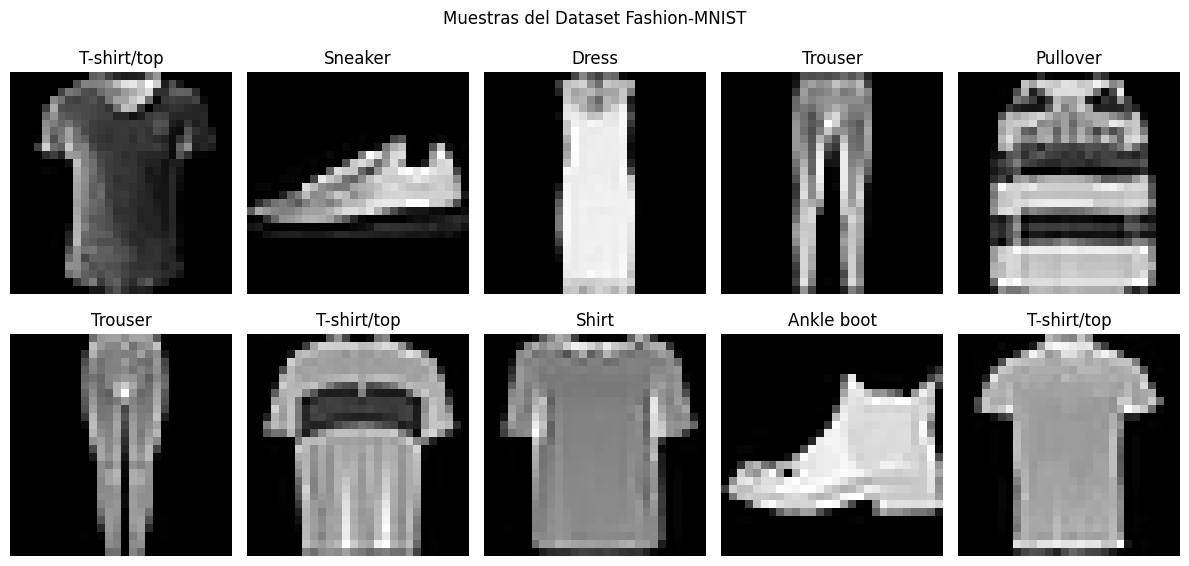


=== SIMULANDO DESBALANCE EN CLASE 5 (Sandal) ===
Distribución después del desbalance:
  Clase 0 (T-shirt/top): 4800 muestras
  Clase 1 (Trouser): 4800 muestras
  Clase 2 (Pullover): 4800 muestras
  Clase 3 (Dress): 4800 muestras
  Clase 4 (Coat): 4800 muestras
  Clase 5 (Sandal): 480 muestras
  Clase 6 (Shirt): 4800 muestras
  Clase 7 (Sneaker): 4800 muestras
  Clase 8 (Bag): 4800 muestras
  Clase 9 (Ankle boot): 4800 muestras

FASE 1: CNN PARA CLASIFICACIÓN
=== CONSTRUYENDO CNN MODEL ===
Modelo CNN compilado exitosamente


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,180,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,836,554 (7.01 MB)

 Trainable params: 1,836,554 (7.01 MB)

 Non-trainable params: 0 (0.00 B)


=== ENTRENANDO CNN ===
Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.6473 - loss: 0.9647
Epoch 1: val_accuracy improved from -inf to 0.84050, saving model to best_cnn_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 148s 664ms/step - accuracy: 0.6478 - loss: 0.9634 - val_accuracy: 0.8405 - val_loss: 0.4344 - learning_rate: 0.0010
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.8483 - loss: 0.4141
Epoch 2: val_accuracy improved from 0.84050 to 0.88233, saving model to best_cnn_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 204s 675ms/step - accuracy: 0.8483 - loss: 0.4139 - val_accuracy: 0.8823 - val_loss: 0.3217 - learning_rate: 0.0010
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.8782 - loss: 0.3303
Epoch 3: val_accuracy improved from 0.88233 to 0.89567, saving model to best_cnn_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 215s 737ms/step - accuracy: 0.8783 - loss: 0.3302 - val_accuracy: 0.8957 - val_loss: 0.2871 - learning_rate: 0.0010
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.8930 - loss: 0.2942
Epoch 4: val_accuracy improved from 0.89567 to 0.89700, saving model to best_cnn_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 218s 812ms/step - accuracy: 0.8930 - loss: 0.2942 - val_accuracy: 0.8970 - val_loss: 0.2717 - learning_rate: 0.0010
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9057 - loss: 0.2572
Epoch 5: val_accuracy improved from 0.89700 to 0.90075, saving model to best_cnn_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 184s 726ms/step - accuracy: 0.9057 - loss: 0.2572 - val_accuracy: 0.9007 - val_loss: 0.2755 - learning_rate: 0.0010
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.9124 - loss: 0.2338
Epoch 6: val_accuracy improved from 0.90075 to 0.90600, saving model to best_cnn_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 185s 650ms/step - accuracy: 0.9125 - loss: 0.2338 - val_accuracy: 0.9060 - val_loss: 0.2603 - learning_rate: 0.0010
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.9209 - loss: 0.2142
Epoch 7: val_accuracy improved from 0.90600 to 0.90925, saving model to best_cnn_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 207s 673ms/step - accuracy: 0.9209 - loss: 0.2142 - val_accuracy: 0.9093 - val_loss: 0.2652 - learning_rate: 0.0010
Epoch 8/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.9255 - loss: 0.1936
Epoch 8: val_accuracy did not improve from 0.90925
219/219 ━━━━━━━━━━━━━━━━━━━━ 147s 672ms/step - accuracy: 0.9255 - loss: 0.1936 - val_accuracy: 0.9013 - val_loss: 0.3250 - learning_rate: 0.0010
Epoch 9/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.9355 - loss: 0.1767
Epoch 9: val_accuracy did not improve from 0.90925
219/219 ━━━━━━━━━━━━━━━━━━━━ 148s 673ms/step - accuracy: 0.9355 - loss: 0.1767 - val_accuracy: 0.9076 - val_loss: 0.3157 - learning_rate: 0.0010
Epoch 10/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9359 - loss: 0.1642
Epoch 10: val_accuracy improved from 0.90925 to 0.91417, saving model to best_cnn_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 144s 656ms/step - accuracy: 0.9359 - loss: 0.1642 - val_accuracy: 0.9142 - val_loss: 0.2755 - learning_rate: 0.0010
Epoch 11/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9429 - loss: 0.1513
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: val_accuracy did not improve from 0.91417
219/219 ━━━━━━━━━━━━━━━━━━━━ 212s 703ms/step - accuracy: 0.9429 - loss: 0.1513 - val_accuracy: 0.9069 - val_loss: 0.3335 - learning_rate: 0.0010
Epoch 12/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.9498 - loss: 0.1305
Epoch 12: val_accuracy improved from 0.91417 to 0.92042, saving model to best_cnn_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 191s 651ms/step - accuracy: 0.9499 - loss: 0.1305 - val_accuracy: 0.9204 - val_loss: 0.2661 - learning_rate: 5.0000e-04
Epoch 13/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.9596 - loss: 0.1068
Epoch 13: val_accuracy did not improve from 0.92042
219/219 ━━━━━━━━━━━━━━━━━━━━ 205s 664ms/step - accuracy: 0.9596 - loss: 0.1068 - val_accuracy: 0.9194 - val_loss: 0.3043 - learning_rate: 5.0000e-04
Epoch 14/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.9629 - loss: 0.0945
Epoch 14: val_accuracy did not improve from 0.92042
219/219 ━━━━━━━━━━━━━━━━━━━━ 146s 668ms/step - accuracy: 0.9629 - loss: 0.0945 - val_accuracy: 0.9196 - val_loss: 0.3193 - learning_rate: 5.0000e-04
Epoch 15/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.9686 - loss: 0.0813
Epoch 15: val_accuracy did not improve from 0.92042
219/219 ━━━━━━━━━━━━━━━━━━━━ 212s 715ms/step - accuracy: 0.9686 - loss: 0.0812 - val_accuracy: 0.9153 - val_loss: 0.3638 - learnin

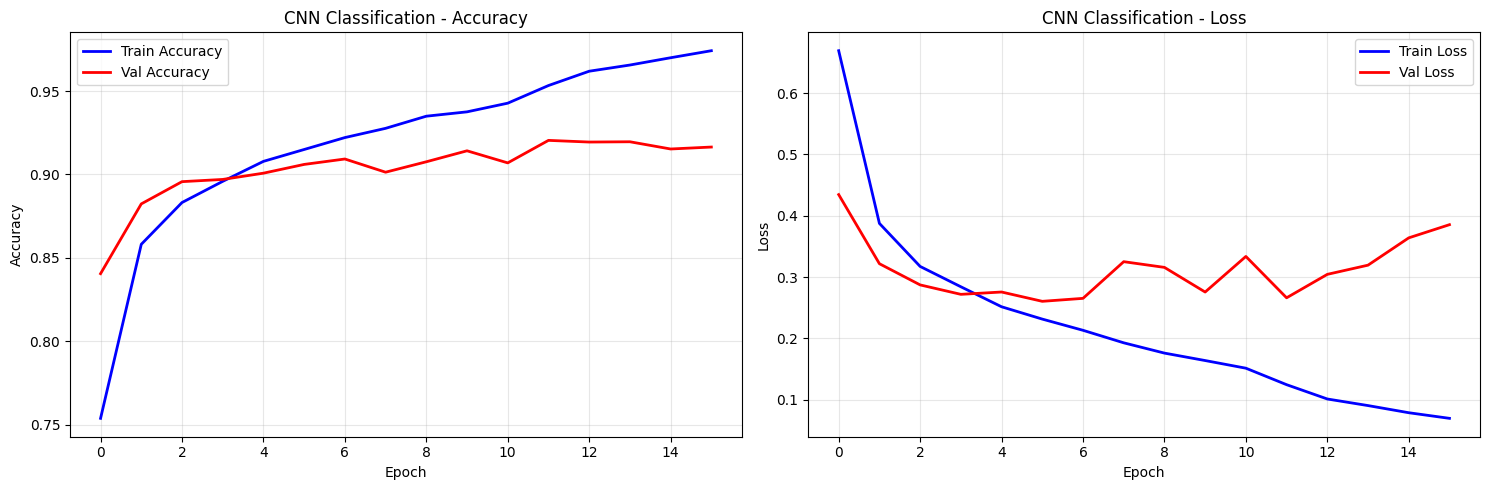

In [12]:
if __name__ == "__main__":
  results = cnn_pipeline()

CONTINUANDO PIPELINE DESDE FASE 2: AUTOENCODER
=== CARGANDO FASHION-MNIST DATASET ===
Dataset info: tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'trai

✅ CNN cargada exitosamente desde best_cnn_model.h5

FASE 2: AUTOENCODER PARA CONTROL DE CALIDAD
=== CONSTRUYENDO AUTOENCODER ===
Autoencoder compilado exitosamente


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Clase normal seleccionada: 0
Muestras de clase normal: 4800

=== ENTRENANDO AUTOENCODER CON CLASE NORMAL ===
Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 27s 198ms/step - loss: 0.0844 - mae: 0.2343 - val_loss: 0.0257 - val_mae: 0.1030 - learning_rate: 2.0000e-04
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - loss: 0.0229 - mae: 0.0961 - val_loss: 0.0190 - val_mae: 0.0824 - learning_rate: 2.0000e-04
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 190ms/step - loss: 0.0181 - mae: 0.0804 - val_loss: 0.0167 - val_mae: 0.0756 - learning_rate: 2.0000e-04
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 206ms/step - loss: 0.0160 - mae: 0.0732 - val_loss: 0.0156 - val_mae: 0.0718 - learning_rate: 2.0000e-04
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 210ms/step - loss: 0.0145 - mae: 0.0683 - val_loss: 0.0139 - val_mae: 0.0661 - learning_rate: 2.0000e-04
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 210ms/step - loss: 0.0135 - mae: 0.0649 - val_loss: 0.0129 - val_mae: 0.0629 - learning_rate: 2.0000e-

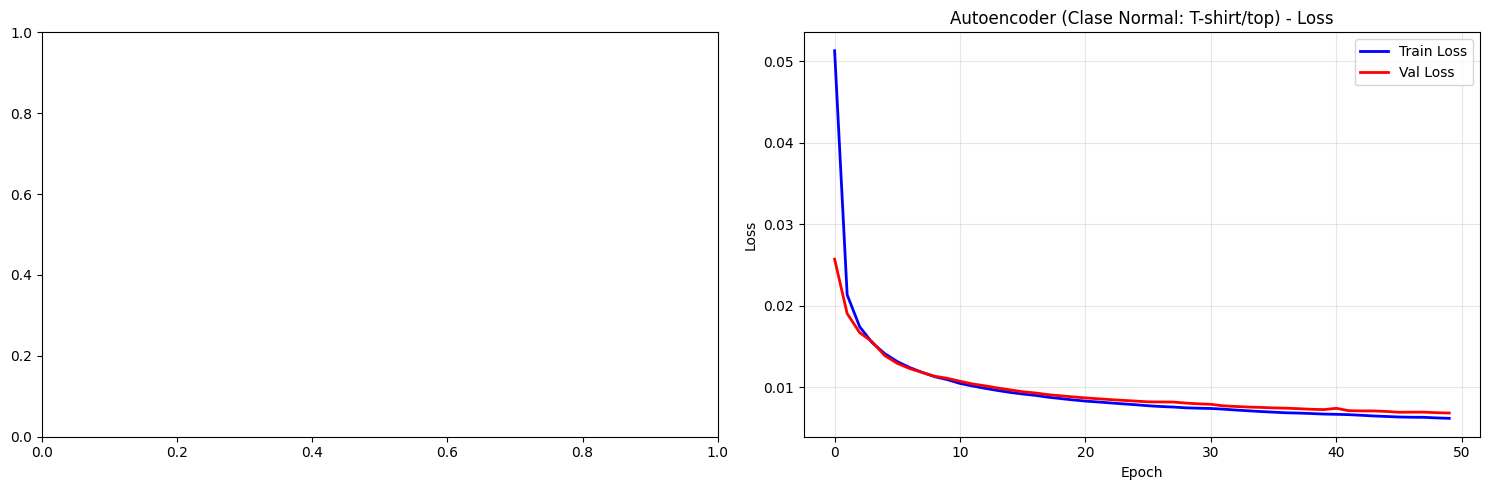


FASE 3: EVALUACIÓN DE MODELOS

=== EVALUACIÓN CNN ===
Test Loss: 0.2967
Test Accuracy: 0.9122


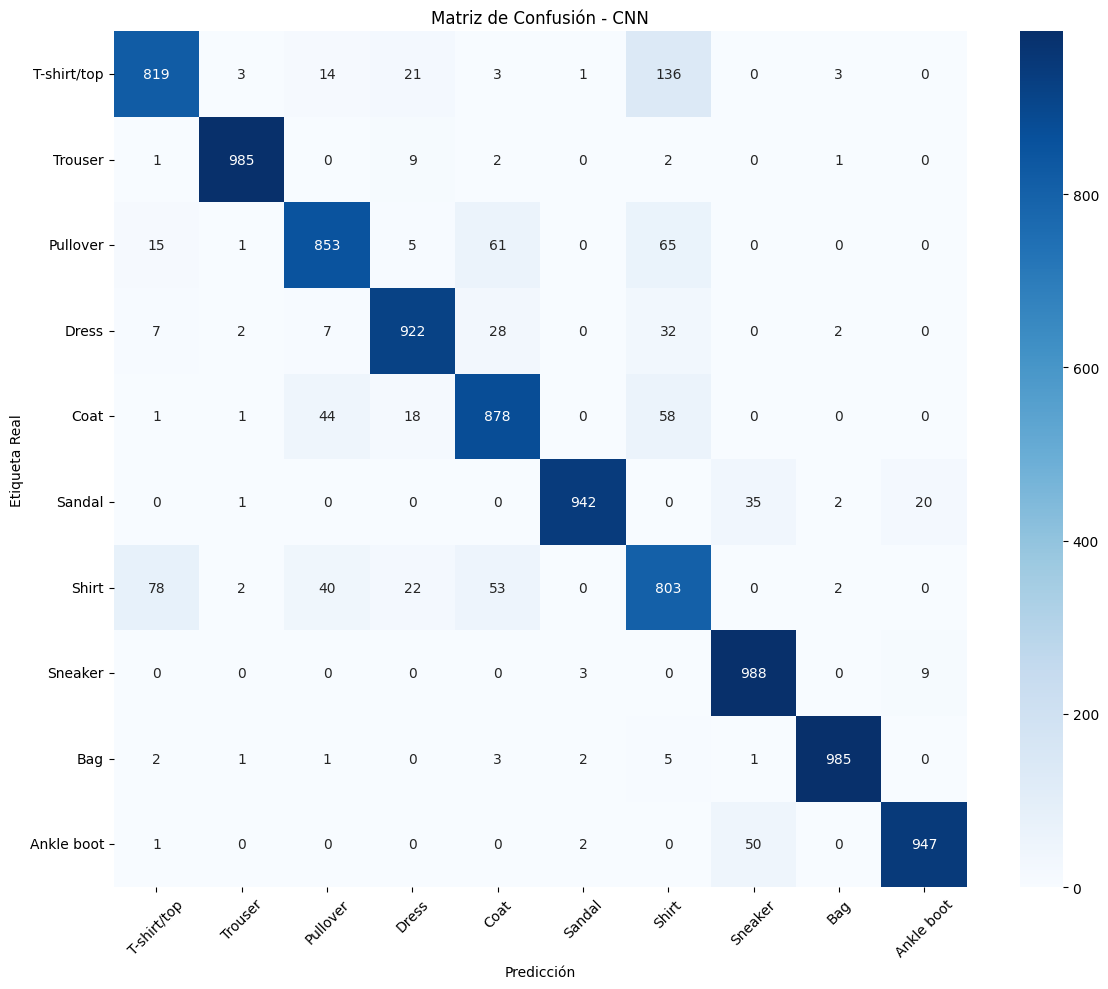


=== REPORTE DE CLASIFICACIÓN ===
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.82      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.89      0.85      0.87      1000
       Dress       0.92      0.92      0.92      1000
        Coat       0.85      0.88      0.87      1000
      Sandal       0.99      0.94      0.97      1000
       Shirt       0.73      0.80      0.76      1000
     Sneaker       0.92      0.99      0.95      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000


=== ACCURACY POR CLASE ===
T-shirt/top: 0.8190
Trouser: 0.9850
Pullover: 0.8530
Dress: 0.9220
Coat: 0.8780
Sandal: 0.9420
Shirt: 0.8030
Sneaker: 0.9880
Bag: 0.9850
Ankle boot: 0.9470

=== EVALUACIÓN AUTOENC

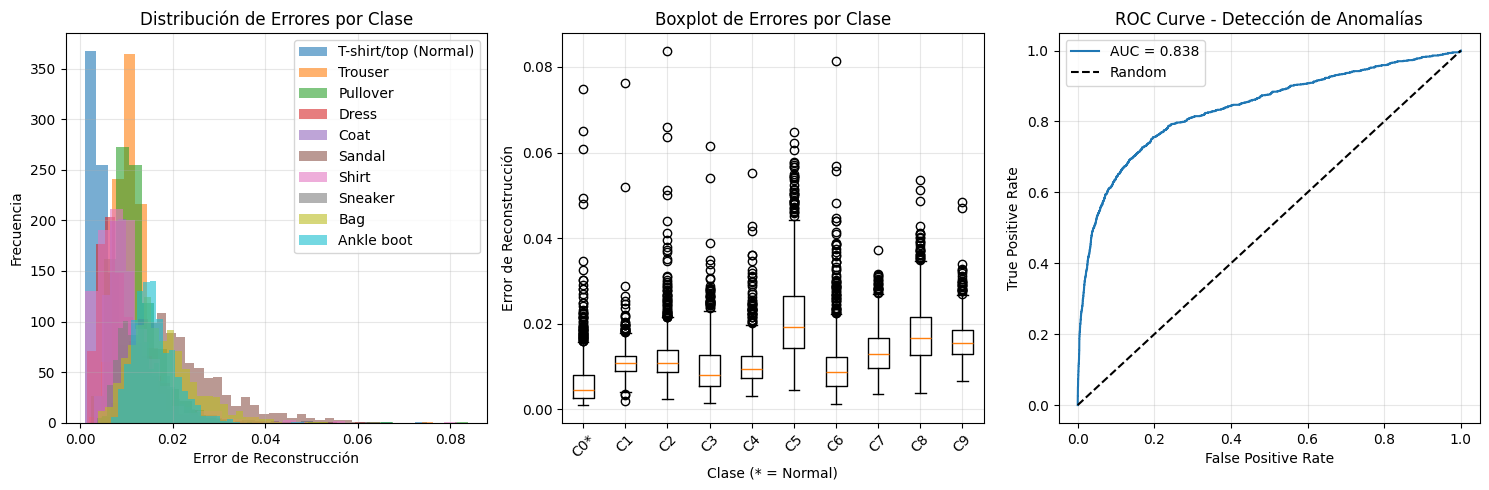


=== ESTADÍSTICAS DE ERROR POR CLASE ===
T-shirt/top:
  Media: 0.006482
  Std: 0.006308
  Min: 0.001029
  Max: 0.074884
Trouser:
  Media: 0.011067
  Std: 0.003888
  Min: 0.002006
  Max: 0.076312
Pullover:
  Media: 0.012188
  Std: 0.006389
  Min: 0.002430
  Max: 0.083812
Dress:
  Media: 0.009732
  Std: 0.006113
  Min: 0.001487
  Max: 0.061471
Coat:
  Media: 0.010667
  Std: 0.005073
  Min: 0.003056
  Max: 0.055119
Sandal:
  Media: 0.021511
  Std: 0.010006
  Min: 0.004577
  Max: 0.064883
Shirt:
  Media: 0.010254
  Std: 0.007498
  Min: 0.001174
  Max: 0.081365
Sneaker:
  Media: 0.013762
  Std: 0.005231
  Min: 0.003666
  Max: 0.037231
Bag:
  Media: 0.017855
  Std: 0.007198
  Min: 0.003819
  Max: 0.053476
Ankle boot:
  Media: 0.016081
  Std: 0.004690
  Min: 0.006741
  Max: 0.048376


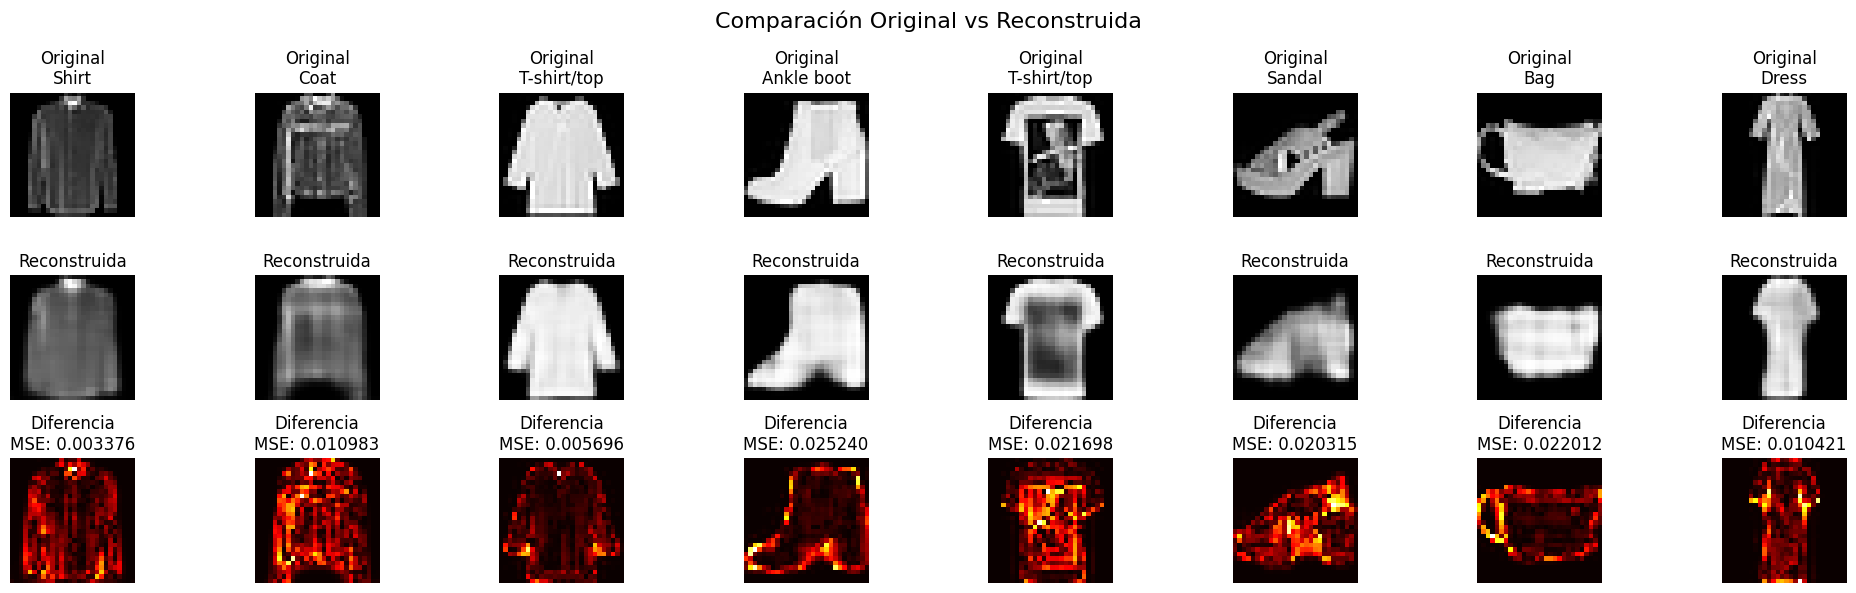


FASE 4: SISTEMA DE DECISIÓN EN PRODUCCIÓN
Umbral de confianza: 0.85
Umbral de reconstrucción: 0.017050

=== MÉTRICAS DE PRODUCCIÓN ===
Total de muestras: 10000
Tasa de aceptación: 0.678
Rechazos por baja confianza: 0.118
Rechazos por calidad: 0.203
Para revisión: 0.000
Confianza media: 0.952
Confianza P10: 0.808
Error reconstrucción medio: 0.012960
Error reconstrucción P95: 0.027019


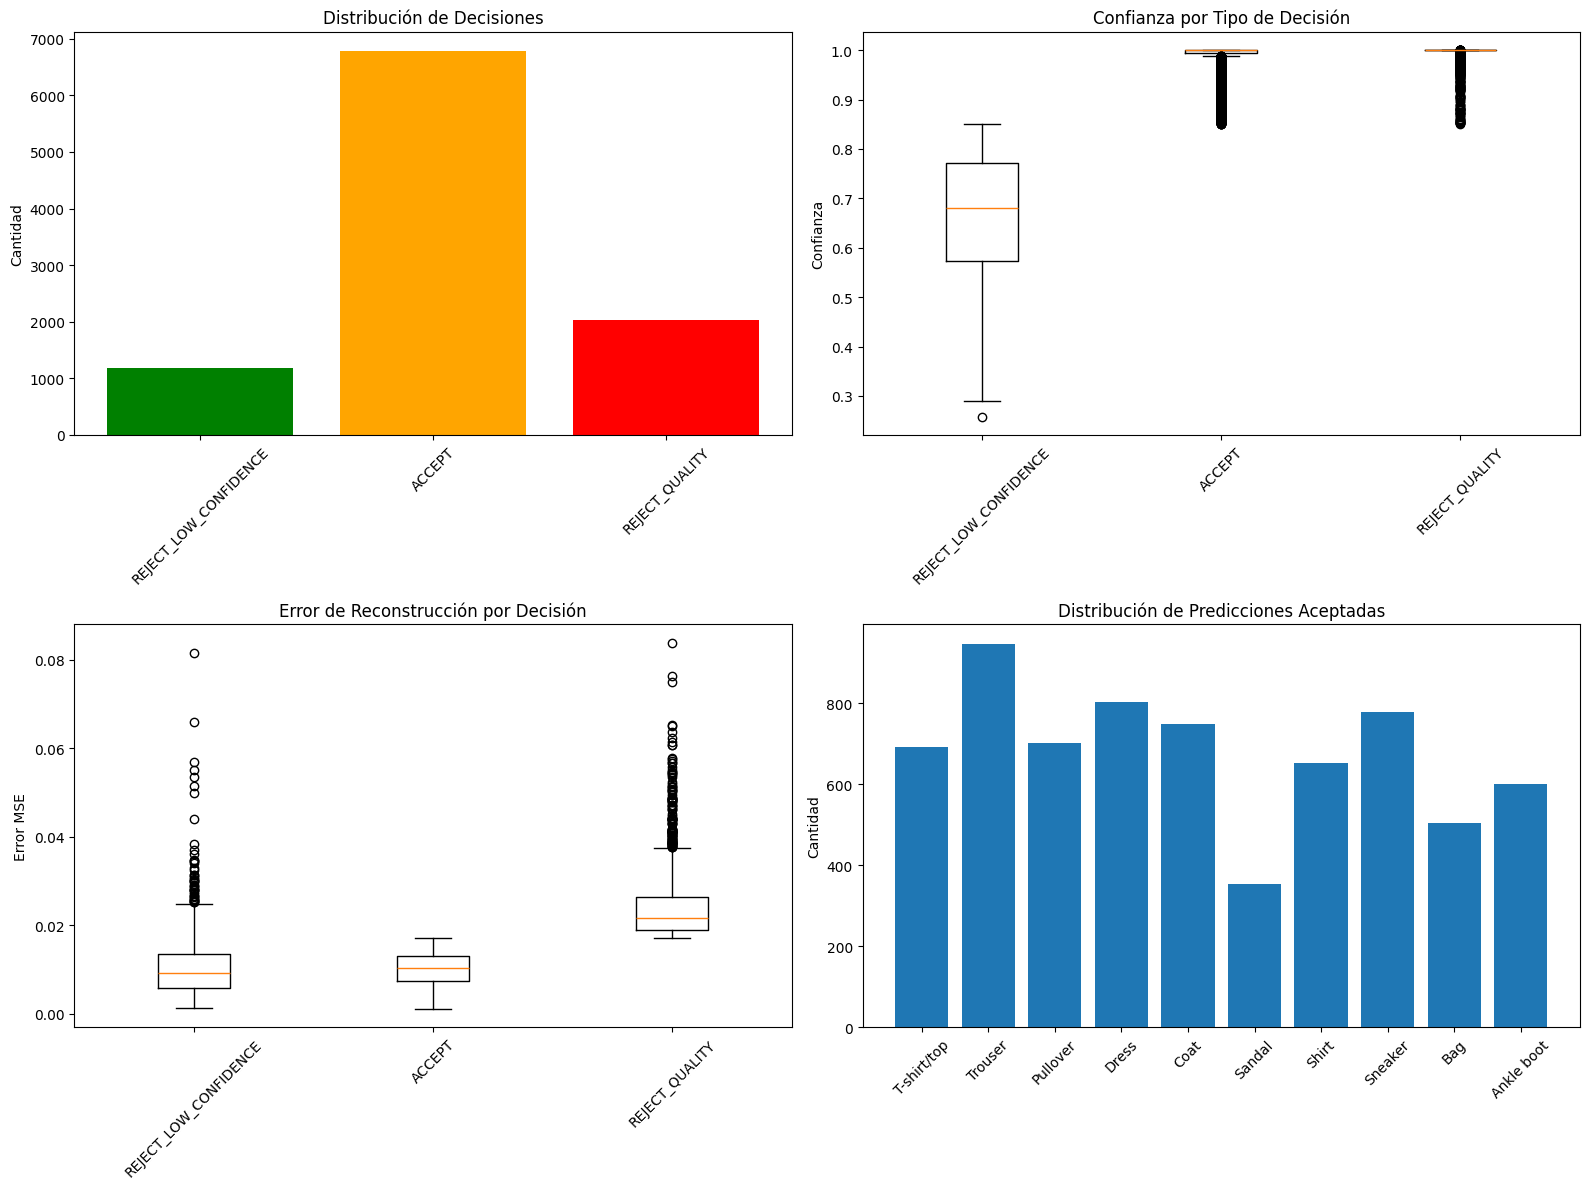


FASE 5: SIMULACIÓN DE MONITOREO EN PRODUCCIÓN

=== SIMULANDO MONITOREO EN PRODUCCIÓN ===
Analizando 10 batches de 1000 muestras cada uno...


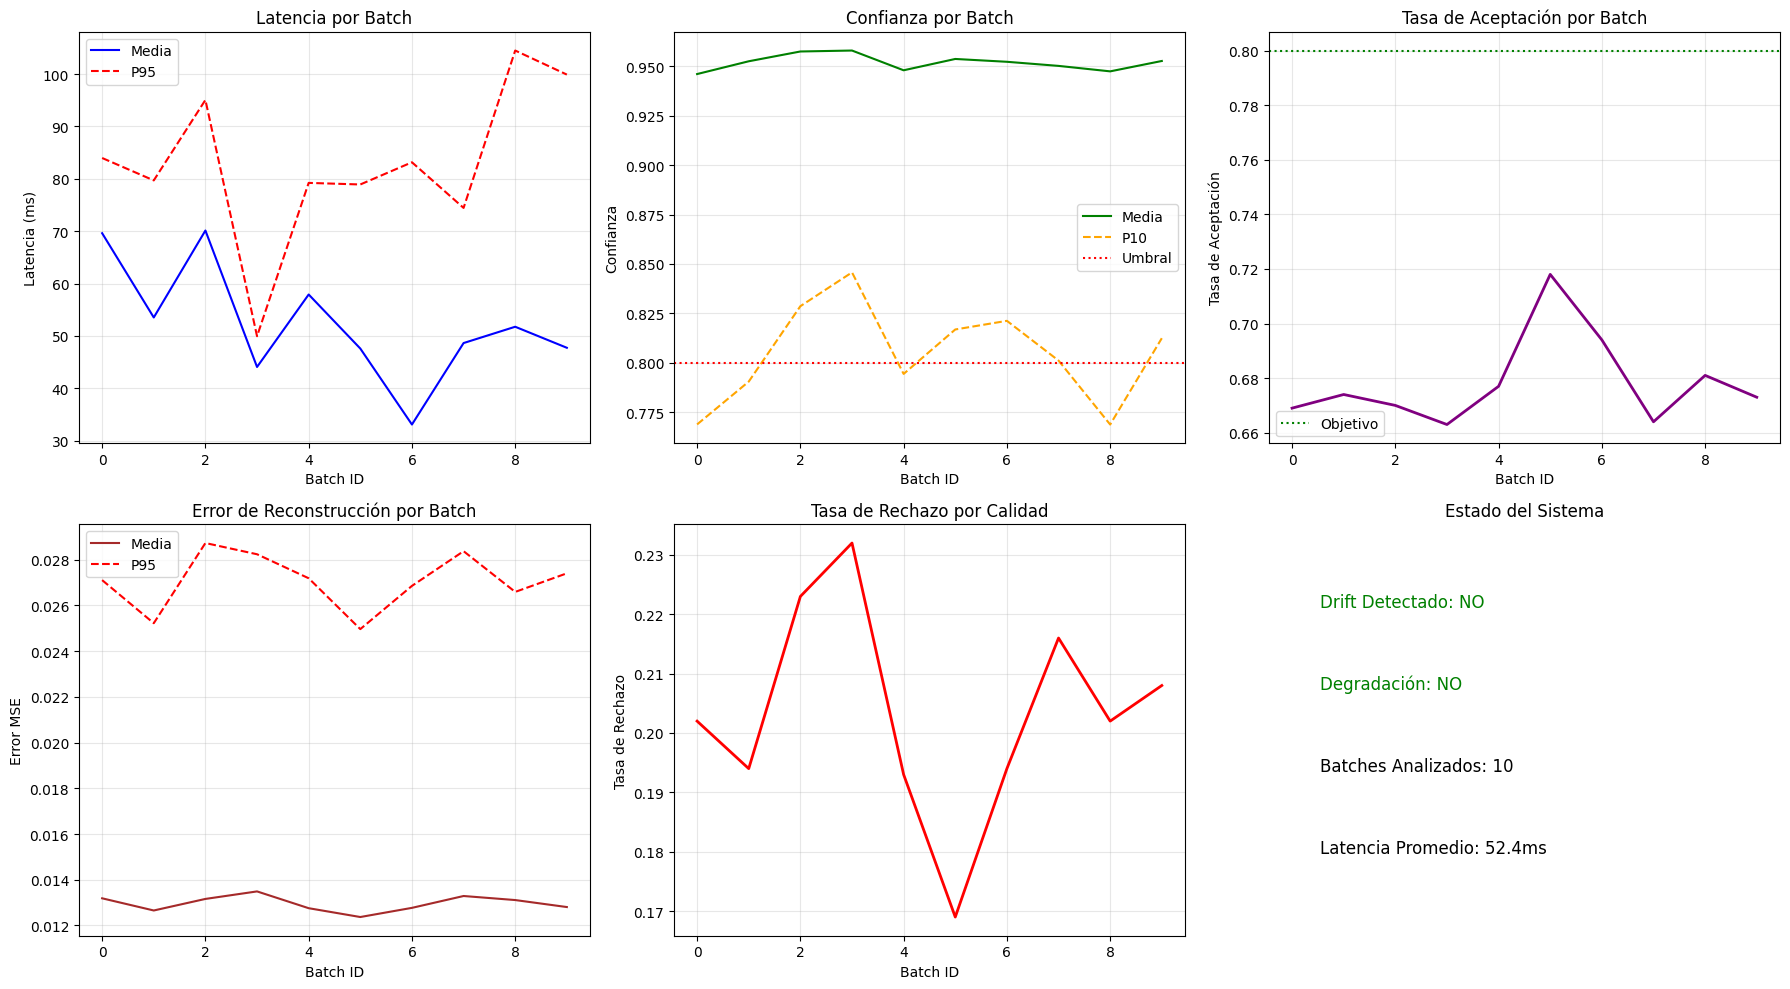


=== ESTADÍSTICAS DE MONITOREO ===
Latencia promedio: 52.41ms
Latencia P95: 82.88ms
Confianza promedio: 0.9518
Tasa de aceptación promedio: 0.6783
Drift detectado: NO
Degradación de rendimiento: NO

RESUMEN FINAL DEL PROYECTO

🎯 RESULTADOS CNN:
   - Accuracy en test: 0.9122
   - Loss en test: 0.2967
   - Clase con mejor accuracy: Sneaker
   - Clase con peor accuracy: Shirt

🔍 RESULTADOS AUTOENCODER:
   - AUC Score: 0.8382
   - Clase normal utilizada: T-shirt/top

🏭 MÉTRICAS DE PRODUCCIÓN:
   - Tasa de aceptación: 67.8%
   - Calidad del sistema: 79.7%

💾 GUARDANDO MODELOS...
   - fashion_mnist_cnn_final.h5
   - fashion_mnist_autoencoder_final.h5

🎉 PIPELINE COMPLETADO EXITOSAMENTE


In [13]:
def continue_pipeline_from_autoencoder():
    """
    Continúa el pipeline desde la FASE 2 (Autoencoder) en adelante
    Reutiliza la CNN ya entrenada y los datos ya preparados
    """
    print("="*80)
    print("CONTINUANDO PIPELINE DESDE FASE 2: AUTOENCODER")
    print("="*80)

    # 1. Cargar datos (rápido, solo preparación)
    data_preparer = FashionMNISTDataPreparer()
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = data_preparer.load_and_preprocess_data()

    # Simular desbalance (rápido)
    X_train_imb, y_train_imb = data_preparer.simulate_class_imbalance(
        X_train, y_train, minority_class=5, keep_ratio=0.1
    )

    # 2. Cargar CNN ya entrenada
    print("🔄 Cargando CNN previamente entrenada...")
    try:
        from tensorflow.keras.models import load_model
        cnn_model = load_model('best_cnn_model.h5')
        print("✅ CNN cargada exitosamente desde best_cnn_model.h5")

        # Crear objeto CNN para mantener compatibilidad
        cnn = FashionMNISTCNN()
        cnn.model = cnn_model

    except:
        print("⚠️  No se pudo cargar CNN previa, entrenando nueva (esto tomará tiempo)...")
        cnn = FashionMNISTCNN()
        cnn.build_model()
        cnn.compile_model(learning_rate=0.001)
        history_cnn = cnn.train(X_train_imb, y_train_imb, X_val, y_val, epochs=30, batch_size=200)

    # 3. FASE 2: AUTOENCODER (desde aquí comenzó el error)
    print("\n" + "="*60)
    print("FASE 2: AUTOENCODER PARA CONTROL DE CALIDAD")
    print("="*60)

    autoencoder = FashionMNISTAutoencoder()
    autoencoder.build_model()
    autoencoder.compile_model(learning_rate=0.0002)

    # Preparar datos de clase normal (clase 0 - T-shirt/top)
    normal_class = 0
    X_normal = autoencoder.prepare_normal_class_data(X_train, y_train, normal_class)

    # Entrenamiento Autoencoder
    history_ae = autoencoder.train(
        X_normal, epochs=50, batch_size=32, validation_split=0.2
    )

    plot_training_history(history_ae, f"Autoencoder (Clase Normal: {data_preparer.class_names[normal_class]})")

    # 4. Evaluación de modelos
    print("\n" + "="*60)
    print("FASE 3: EVALUACIÓN DE MODELOS")
    print("="*60)

    evaluator = ModelEvaluator(data_preparer.class_names)

    # Evaluación CNN
    cnn_results = evaluator.evaluate_cnn(cnn.model, X_test, y_test)

    # Evaluación Autoencoder
    ae_results = evaluator.evaluate_autoencoder(autoencoder, X_test, y_test, normal_class)

    # Visualizar reconstrucciones
    visualize_reconstruction_samples(autoencoder, X_test, y_test, data_preparer.class_names, n_samples=8)

    # 5. Sistema de decisión en producción
    print("\n" + "="*60)
    print("FASE 4: SISTEMA DE DECISIÓN EN PRODUCCIÓN")
    print("="*60)

    # Configurar umbrales basados en resultados
    confidence_threshold = 0.85
    reconstruction_threshold = np.percentile(ae_results['reconstruction_errors'][y_test == normal_class], 95)

    print(f"Umbral de confianza: {confidence_threshold}")
    print(f"Umbral de reconstrucción: {reconstruction_threshold:.6f}")

    # Crear sistema de decisión
    decision_system = ProductionDecisionSystem(
        cnn.model, autoencoder, data_preparer.class_names,
        confidence_threshold=confidence_threshold,
        reconstruction_threshold=reconstruction_threshold
    )

    # Hacer predicciones en conjunto de test
    decisions = decision_system.predict_with_quality_check(X_test)

    # Calcular métricas de producción
    prod_metrics = decision_system.get_production_metrics(decisions)

    print("\n=== MÉTRICAS DE PRODUCCIÓN ===")
    print(f"Total de muestras: {prod_metrics['total_samples']}")
    print(f"Tasa de aceptación: {prod_metrics['accept_rate']:.3f}")
    print(f"Rechazos por baja confianza: {prod_metrics['reject_confidence_rate']:.3f}")
    print(f"Rechazos por calidad: {prod_metrics['reject_quality_rate']:.3f}")
    print(f"Para revisión: {prod_metrics['review_rate']:.3f}")
    print(f"Confianza media: {prod_metrics['mean_confidence']:.3f}")
    print(f"Confianza P10: {prod_metrics['p10_confidence']:.3f}")
    print(f"Error reconstrucción medio: {prod_metrics['mean_reconstruction_error']:.6f}")
    print(f"Error reconstrucción P95: {prod_metrics['p95_reconstruction_error']:.6f}")

    # 6. Visualización de decisiones de producción
    visualize_production_decisions(decisions, prod_metrics, data_preparer.class_names)

    # 7. Análisis de drift y monitoreo
    print("\n" + "="*60)
    print("FASE 5: SIMULACIÓN DE MONITOREO EN PRODUCCIÓN")
    print("="*60)

    monitor_results = simulate_production_monitoring(
        decision_system, X_test, y_test, data_preparer.class_names
    )

    # 8. Resumen final
    print("\n" + "="*80)
    print("RESUMEN FINAL DEL PROYECTO")
    print("="*80)

    print(f"\n🎯 RESULTADOS CNN:")
    print(f"   - Accuracy en test: {cnn_results['accuracy']:.4f}")
    print(f"   - Loss en test: {cnn_results['loss']:.4f}")
    print(f"   - Clase con mejor accuracy: {data_preparer.class_names[np.argmax(cnn_results['class_accuracies'])]}")
    print(f"   - Clase con peor accuracy: {data_preparer.class_names[np.argmin(cnn_results['class_accuracies'])]}")

    print(f"\n🔍 RESULTADOS AUTOENCODER:")
    print(f"   - AUC Score: {ae_results['auc_score']:.4f}")
    print(f"   - Clase normal utilizada: {data_preparer.class_names[normal_class]}")

    print(f"\n🏭 MÉTRICAS DE PRODUCCIÓN:")
    print(f"   - Tasa de aceptación: {prod_metrics['accept_rate']*100:.1f}%")
    print(f"   - Calidad del sistema: {(1-prod_metrics['reject_quality_rate'])*100:.1f}%")

    # Guardar modelos
    print(f"\n💾 GUARDANDO MODELOS...")
    cnn.model.save('fashion_mnist_cnn_final.h5')
    autoencoder.model.save('fashion_mnist_autoencoder_final.h5')
    print("   - fashion_mnist_cnn_final.h5")
    print("   - fashion_mnist_autoencoder_final.h5")

    return {
        'cnn_model': cnn.model,
        'autoencoder_model': autoencoder.model,
        'cnn_results': cnn_results,
        'ae_results': ae_results,
        'production_metrics': prod_metrics,
        'monitoring_results': monitor_results,
        'data_preparer': data_preparer
    }


# Función para ejecutar solo desde el autoencoder
if __name__ == "__main__":
    # Ejecutar pipeline desde autoencoder
    results = continue_pipeline_from_autoencoder()

    print("\n" + "="*80)
    print("🎉 PIPELINE COMPLETADO EXITOSAMENTE")
    print("="*80)

Predicciones por cada clase

In [16]:
# =========================================================
# PREDICCIONES POR CADA CLASE (0-9)
# =========================================================

def calculate_reconstruction_error_direct(autoencoder_model, X):
    """
    Calcula el error de reconstrucción directamente con el modelo de Keras
    """
    reconstructed = autoencoder_model.predict(X, verbose=0)
    mse_errors = np.mean(np.square(X - reconstructed), axis=(1, 2, 3))
    return mse_errors

def predict_samples_by_class_fixed(cnn_model, autoencoder_model, decision_system,
                                 X_test, y_test, class_names):
    """
    Hace una predicción por cada clase del dataset
    """
    print("\n" + "="*80)
    print("PREDICCIONES INDIVIDUALES POR CLASE")
    print("="*80)

    results_by_class = {}

    # Para cada clase (0-9)
    for class_id in range(10):
        # Encontrar una muestra de esta clase en el conjunto de test
        class_indices = np.where(y_test == class_id)[0]

        if len(class_indices) > 0:
            # Seleccionar una muestra aleatoria de esta clase
            sample_idx = np.random.choice(class_indices)
            sample_image = X_test[sample_idx:sample_idx+1]  # Mantener dimensión batch
            true_label = y_test[sample_idx]

            # Hacer predicción con CNN
            cnn_prediction_prob = cnn_model.predict(sample_image, verbose=0)
            cnn_prediction = np.argmax(cnn_prediction_prob, axis=1)[0]
            cnn_confidence = np.max(cnn_prediction_prob)

            # Calcular error de reconstrucción directamente
            reconstruction_error = calculate_reconstruction_error_direct(autoencoder_model, sample_image)[0]

            # Usar sistema de decisión completo
            decision_result = decision_system.predict_with_quality_check(sample_image)[0]

            # Determinar resultado binario (0 o 1)
            binary_result = 1 if decision_result['decision'] == 'ACCEPT' else 0

            # Guardar resultados
            results_by_class[class_id] = {
                'true_label': true_label,
                'predicted_label': cnn_prediction,
                'confidence': cnn_confidence,
                'reconstruction_error': reconstruction_error,
                'decision': decision_result['decision'],
                'binary_result': binary_result,
                'sample_index': sample_idx
            }

            print(f"Clase {class_id} ({class_names[class_id]}):")
            print(f"  └── Etiqueta real: {true_label} | Predicción: {cnn_prediction}")
            print(f"  └── Confianza: {cnn_confidence:.4f} | Error reconstrucción: {reconstruction_error:.6f}")
            print(f"  └── Decisión: {decision_result['decision']} | Resultado binario: {binary_result}")
            print()
        else:
            print(f"⚠️  No se encontraron muestras de la clase {class_id}")
            results_by_class[class_id] = None

    return results_by_class

In [17]:
# =========================================================
# EJECUCIÓN
# =========================================================

# Ejecutar después de que el pipeline esté completo
if 'results' in locals() and results is not None:
    print("✅ Usando modelos del pipeline completado...")

    # Cargar datos de test
    data_preparer = FashionMNISTDataPreparer()
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = data_preparer.load_and_preprocess_data()

    # Recrear sistema de decisión con los modelos entrenados
    confidence_threshold = 0.85
    normal_class = 0

    # Calcular threshold de reconstrucción usando el modelo directo
    print("🔄 Calculando umbral de reconstrucción...")
    normal_class_indices = np.where(y_test == normal_class)[0]
    normal_samples = X_test[normal_class_indices[:100]]  # Usar 100 muestras para calcular umbral
    normal_errors = calculate_reconstruction_error_direct(results['autoencoder_model'], normal_samples)
    reconstruction_threshold = np.percentile(normal_errors, 95)

    print(f"Umbral de reconstrucción calculado: {reconstruction_threshold:.6f}")

    # Crear sistema de decisión personalizado
    class FixedProductionDecisionSystem:
        def __init__(self, cnn_model, autoencoder_model, class_names,
                     confidence_threshold=0.8, reconstruction_threshold=0.01):
            self.cnn_model = cnn_model
            self.autoencoder_model = autoencoder_model
            self.class_names = class_names
            self.confidence_threshold = confidence_threshold
            self.reconstruction_threshold = reconstruction_threshold

        def predict_with_quality_check(self, X):
            # Predicción CNN
            predictions_prob = self.cnn_model.predict(X, verbose=0)
            predictions = np.argmax(predictions_prob, axis=1)
            max_confidences = np.max(predictions_prob, axis=1)

            # Error de reconstrucción usando función directa
            reconstruction_errors = calculate_reconstruction_error_direct(self.autoencoder_model, X)

            # Decisiones
            decisions = []
            for i in range(len(X)):
                confidence = max_confidences[i]
                error = reconstruction_errors[i]
                pred_class = predictions[i]

                # Lógica de decisión
                if confidence >= self.confidence_threshold and error <= self.reconstruction_threshold:
                    decision = "ACCEPT"
                elif confidence < self.confidence_threshold:
                    decision = "REJECT_LOW_CONFIDENCE"
                elif error > self.reconstruction_threshold:
                    decision = "REJECT_QUALITY"
                else:
                    decision = "REVIEW"

                decisions.append({
                    'prediction': pred_class,
                    'class_name': self.class_names[pred_class],
                    'confidence': confidence,
                    'reconstruction_error': error,
                    'decision': decision
                })

            return decisions

    # Crear sistema de decisión corregido
    decision_system = FixedProductionDecisionSystem(
        results['cnn_model'],
        results['autoencoder_model'],
        data_preparer.class_names,
        confidence_threshold=confidence_threshold,
        reconstruction_threshold=reconstruction_threshold
    )

    print(f"✅ Sistema de decisión creado con umbrales:")
    print(f"   - Confianza: {confidence_threshold}")
    print(f"   - Reconstrucción: {reconstruction_threshold:.6f}")

    # Hacer predicciones por clase
    class_predictions = predict_samples_by_class_fixed(
        results['cnn_model'],
        results['autoencoder_model'],
        decision_system,
        X_test,
        y_test,
        data_preparer.class_names
    )

else:
    print("⚠️  Ejecuta primero el pipeline principal para obtener los modelos entrenados")

✅ Usando modelos del pipeline completado...
=== CARGANDO FASHION-MNIST DATASET ===
Dataset info: tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train':

Fast API

In [18]:
pip install fastapi uvicorn python-multipart gradio pillow scipy

In [19]:
# =========================================================
# 7. API DE DESPLIEGUE CON FASTAPI (MEJORADA)
# =========================================================

def create_fastapi_app(cnn_model, autoencoder_model, decision_system, class_names):
    """
    Crea una aplicación FastAPI para despliegue del modelo
    """
    try:
        from fastapi import FastAPI, File, UploadFile, HTTPException
        from fastapi.responses import JSONResponse
        import io
        from PIL import Image

        app = FastAPI(title="Fashion-MNIST Classifier API", version="1.0.0")

        @app.get("/")
        async def root():
            return {"message": "Fashion-MNIST Classifier API", "version": "1.0.0"}

        @app.get("/health")
        async def health_check():
            return {
                "status": "healthy",
                "model_loaded": cnn_model is not None and autoencoder_model is not None,
                "classes": len(class_names)
            }

        @app.post("/predict")
        async def predict(file: UploadFile = File(...)):
            try:
                # Validar tipo de archivo
                if not file.content_type.startswith('image/'):
                    raise HTTPException(status_code=400, detail="El archivo debe ser una imagen")

                # Leer imagen
                contents = await file.read()
                image = Image.open(io.BytesIO(contents))

                # Preprocesar imagen
                if image.mode != 'L':
                    image = image.convert('L')
                image = image.resize((28, 28))

                # Convertir a array y normalizar
                img_array = np.array(image).astype('float32') / 255.0
                img_array = img_array.reshape(1, 28, 28, 1)

                # Hacer predicción con sistema de decisión
                decisions = decision_system.predict_with_quality_check(img_array)
                result = decisions[0]

                return JSONResponse({
                    "success": True,
                    "prediction": int(result['prediction']),
                    "class_name": result['class_name'],
                    "confidence": float(result['confidence']),
                    "reconstruction_error": float(result['reconstruction_error']),
                    "decision": result['decision'],
                    "quality_check": "PASS" if result['decision'] == "ACCEPT" else "FAIL",
                    "binary_result": 1 if result['decision'] == "ACCEPT" else 0
                })

            except Exception as e:
                return JSONResponse({
                    "success": False,
                    "error": str(e)
                }, status_code=500)

        return app

    except ImportError as e:
        print(f"FastAPI no está disponible. Error: {e}")
        print("Instalar con: pip install fastapi uvicorn python-multipart")
        return None

In [24]:
# =========================================================
# FUNCIÓN HELPER PARA CALCULAR ERROR DE RECONSTRUCCIÓN
# =========================================================

def calculate_reconstruction_error_direct(autoencoder_model, X):
    """
    Calcula el error de reconstrucción directamente con el modelo de Keras
    """
    reconstructed = autoencoder_model.predict(X, verbose=0)
    mse_errors = np.mean(np.square(X - reconstructed), axis=(1, 2, 3))
    return mse_errors

# =========================================================
# SISTEMA DE DECISIÓN PARA GRADIO
# =========================================================

class FixedProductionDecisionSystem:
    """
    Sistema de decisión que usa función directa para calcular error de reconstrucción
    """
    def __init__(self, cnn_model, autoencoder_model, class_names,
                 confidence_threshold=0.8, reconstruction_threshold=0.01):
        self.cnn_model = cnn_model
        self.autoencoder_model = autoencoder_model
        self.class_names = class_names
        self.confidence_threshold = confidence_threshold
        self.reconstruction_threshold = reconstruction_threshold

    def predict_with_quality_check(self, X):
        """
        Predicción con verificación de calidad - VERSIÓN CORREGIDA
        """
        # Predicción CNN
        predictions_prob = self.cnn_model.predict(X, verbose=0)
        predictions = np.argmax(predictions_prob, axis=1)
        max_confidences = np.max(predictions_prob, axis=1)

        # Error de reconstrucción usando función directa
        reconstruction_errors = calculate_reconstruction_error_direct(self.autoencoder_model, X)

        # Decisiones
        decisions = []
        for i in range(len(X)):
            confidence = max_confidences[i]
            error = reconstruction_errors[i]
            pred_class = predictions[i]

            # Lógica de decisión
            if confidence >= self.confidence_threshold and error <= self.reconstruction_threshold:
                decision = "ACCEPT"
            elif confidence < self.confidence_threshold:
                decision = "REJECT_LOW_CONFIDENCE"
            elif error > self.reconstruction_threshold:
                decision = "REJECT_QUALITY"
            else:
                decision = "REVIEW"

            decisions.append({
                'prediction': pred_class,
                'class_name': self.class_names[pred_class],
                'confidence': confidence,
                'reconstruction_error': error,
                'decision': decision
            })

        return decisions

In [31]:
# =========================================================
# FUNCIÓN PARA ENCONTRAR PUERTO DISPONIBLE
# =========================================================

import socket

def find_free_port(start_port=7860, max_attempts=50):
    """
    Encuentra un puerto libre comenzando desde start_port
    """
    for port in range(start_port, start_port + max_attempts):
        try:
            with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
                s.bind(('localhost', port))
                return port
        except OSError:
            continue
    raise RuntimeError(f"No se pudo encontrar un puerto libre en el rango {start_port}-{start_port + max_attempts}")

# =========================================================
# FUNCIÓN PARA CALCULAR ERROR DE RECONSTRUCCIÓN
# =========================================================

def calculate_reconstruction_error_direct(autoencoder_model, X):
    """
    Calcula el error de reconstrucción directamente con el modelo de Keras
    """
    reconstructed = autoencoder_model.predict(X, verbose=0)
    mse_errors = np.mean(np.square(X - reconstructed), axis=(1, 2, 3))
    return mse_errors

In [32]:
# =========================================================
# SISTEMA DE DECISIÓN PARA GRADIO (MEJORADO)
# =========================================================

class FixedProductionDecisionSystem:
    """
    Sistema de decisión que usa función directa para calcular error de reconstrucción
    """
    def __init__(self, cnn_model, autoencoder_model, class_names,
                 confidence_threshold=0.8, reconstruction_threshold=0.01):
        self.cnn_model = cnn_model
        self.autoencoder_model = autoencoder_model
        self.class_names = class_names
        self.confidence_threshold = confidence_threshold
        self.reconstruction_threshold = reconstruction_threshold

    def predict_with_quality_check(self, X):
        """
        Predicción con verificación de calidad - VERSIÓN CORREGIDA
        """
        # Predicción CNN
        predictions_prob = self.cnn_model.predict(X, verbose=0)
        predictions = np.argmax(predictions_prob, axis=1)
        max_confidences = np.max(predictions_prob, axis=1)

        # Error de reconstrucción usando función directa
        reconstruction_errors = calculate_reconstruction_error_direct(self.autoencoder_model, X)

        # Decisiones
        decisions = []
        for i in range(len(X)):
            confidence = max_confidences[i]
            error = reconstruction_errors[i]
            pred_class = predictions[i]

            # Lógica de decisión
            if confidence >= self.confidence_threshold and error <= self.reconstruction_threshold:
                decision = "ACCEPT"
            elif confidence < self.confidence_threshold:
                decision = "REJECT_LOW_CONFIDENCE"
            elif error > self.reconstruction_threshold:
                decision = "REJECT_QUALITY"
            else:
                decision = "REVIEW"

            decisions.append({
                'prediction': pred_class,
                'class_name': self.class_names[pred_class],
                'confidence': confidence,
                'reconstruction_error': error,
                'decision': decision
            })

        return decisions

In [33]:
# =========================================================
# INTERFAZ GRADIO MEJORADA CON MANEJO DE ERRORES
# =========================================================

def create_gradio_interface_enhanced(cnn_model, autoencoder_model, decision_system, class_names):
    """
    Crea interfaz Gradio mejorada para interacción con el modelo
    """
    try:
        import gradio as gr
        from scipy.ndimage import zoom

        def predict_image(image):
            if image is None:
                return "❌ Por favor, sube una imagen.", "", "", "", ""

            try:
                # Preprocesar imagen
                if len(image.shape) == 3:
                    image = np.mean(image, axis=2)  # Convertir a escala de grises

                # Redimensionar y normalizar
                if image.shape != (28, 28):
                    scale_factors = (28/image.shape[0], 28/image.shape[1])
                    image = zoom(image, scale_factors)

                image = image.astype('float32') / 255.0
                image = image.reshape(1, 28, 28, 1)

                # Hacer predicción usando el sistema corregido
                decisions = decision_system.predict_with_quality_check(image)
                result = decisions[0]

                # Formatear resultados con iconos y colores
                prediction_text = f"🎯 Predicción: {result['class_name']}"
                confidence_text = f"📊 Confianza: {result['confidence']:.4f}"
                error_text = f"🔍 Error de Reconstrucción: {result['reconstruction_error']:.6f}"
                decision_text = f"⚖️ Decisión: {result['decision'].replace('_', ' ')}"

                if result['decision'] == "ACCEPT":
                    status_text = "✅ ACEPTADO - Producto de calidad aceptable"
                elif "CONFIDENCE" in result['decision']:
                    status_text = "⚠️ RECHAZADO - Confianza baja en la predicción"
                elif "QUALITY" in result['decision']:
                    status_text = "❌ RECHAZADO - Calidad de imagen insuficiente"
                else:
                    status_text = "🔄 REQUIERE REVISIÓN MANUAL"

                return (
                    prediction_text,
                    confidence_text,
                    error_text,
                    decision_text,
                    status_text
                )

            except Exception as e:
                error_msg = f"❌ Error procesando imagen: {str(e)}"
                return error_msg, "", "", "", ""

        # Crear ejemplos de texto para ayuda
        examples_description = """
        📝 **Instrucciones de uso:**
        1. Sube una imagen de ropa (preferiblemente 28x28 píxeles)
        2. El sistema automáticamente:
           - Clasificará el tipo de prenda
           - Evaluará la confianza de la predicción
           - Calculará la calidad de la imagen
           - Tomará una decisión final

        🏷️ **Categorías soportadas:**
        T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
        """

        interface = gr.Interface(
            fn=predict_image,
            inputs=gr.Image(
                label="📸 Subir imagen de ropa",
                type="numpy",
                height=300
            ),
            outputs=[
                gr.Textbox(label="🎯 Predicción", lines=1),
                gr.Textbox(label="📊 Confianza", lines=1),
                gr.Textbox(label="🔍 Error de Reconstrucción", lines=1),
                gr.Textbox(label="⚖️ Decisión del Sistema", lines=1),
                gr.Textbox(label="🚦 Estado Final", lines=2)
            ],
            title="🧥 Fashion-MNIST Classifier con Control de Calidad Automático",
            description=examples_description,
            theme=gr.themes.Soft(),
            examples=None,
            allow_flagging="never"
        )

        return interface

    except ImportError as e:
        print(f"❌ Gradio no está disponible. Error: {e}")
        print("💡 Instalar con: pip install gradio scipy")
        return None

In [34]:
# =========================================================
# FUNCIÓN DE DESPLIEGUE MEJORADA CON GESTIÓN DE PUERTOS
# =========================================================

def deploy_models_enhanced(results, deployment_type="gradio", preferred_port=7860):
    """
    Despliega los modelos con gestión automática de puertos
    """
    if results is None:
        print("❌ Error: No hay modelos entrenados. Ejecuta el pipeline principal primero.")
        return None

    try:
        # Extraer componentes necesarios
        cnn_model = results['cnn_model']
        autoencoder_model = results['autoencoder_model']
        data_preparer = results['data_preparer']
        class_names = data_preparer.class_names

        print("🔄 Calculando umbral de reconstrucción...")

        # Calcular umbral de reconstrucción dinámicamente
        try:
            # Cargar datos para calcular umbral
            (X_train, y_train), (X_val, y_val), (X_test, y_test) = data_preparer.load_and_preprocess_data()

            # Usar muestras de la clase normal (clase 0) para calcular umbral
            normal_class = 0
            normal_class_indices = np.where(y_test == normal_class)[0]
            normal_samples = X_test[normal_class_indices[:100]]  # 100 muestras
            normal_errors = calculate_reconstruction_error_direct(autoencoder_model, normal_samples)
            reconstruction_threshold = np.percentile(normal_errors, 95)

            print(f"✅ Umbral calculado: {reconstruction_threshold:.6f}")

        except Exception as e:
            print(f"⚠️  Error calculando umbral dinámico: {e}")
            reconstruction_threshold = 0.01  # Valor por defecto
            print(f"   Usando umbral por defecto: {reconstruction_threshold}")

        # Crear sistema de decisión corregido
        confidence_threshold = 0.85

        decision_system = FixedProductionDecisionSystem(
            cnn_model,
            autoencoder_model,
            class_names,
            confidence_threshold=confidence_threshold,
            reconstruction_threshold=reconstruction_threshold
        )

        print(f"✅ Sistema de decisión creado con umbrales:")
        print(f"   - Confianza: {confidence_threshold}")
        print(f"   - Reconstrucción: {reconstruction_threshold:.6f}")

        if deployment_type.lower() == "gradio":
            # Encontrar puerto disponible
            try:
                available_port = find_free_port(preferred_port)
                print(f"🔍 Puerto {preferred_port} ocupado, usando puerto {available_port}")
            except RuntimeError:
                print(f"❌ No se pudo encontrar un puerto disponible")
                return None

            # Despliegue con Gradio mejorado
            interface = create_gradio_interface_enhanced(cnn_model, autoencoder_model, decision_system, class_names)

            if interface is not None:
                print(f"✅ Interfaz Gradio creada exitosamente")
                print(f"🚀 Lanzando interfaz en puerto {available_port}...")
                print(f"🌐 Accede a: http://localhost:{available_port}")
                print(f"🛑 Para detener: Ctrl+C en la terminal")

                # Lanzar con configuración mejorada
                interface.launch(
                    server_port=available_port,
                    share=False,
                    server_name="0.0.0.0",
                    inbrowser=True,  # Abrir automáticamente en el navegador
                    show_error=True,
                    quiet=False
                )
                return interface
            else:
                print("❌ Error creando interfaz Gradio")
                return None

        else:
            print(f"❌ Tipo de despliegue no reconocido: {deployment_type}")
            print("   Opciones disponibles: 'gradio'")
            return None

    except Exception as e:
        print(f"❌ Error durante el despliegue: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# =========================================================
# FUNCIÓN PARA CERRAR INTERFACES GRADIO ANTERIORES
# =========================================================

def close_gradio_interfaces():
    """
    Intenta cerrar interfaces Gradio anteriores
    """
    try:
        import gradio as gr
        gr.close_all()
        print("✅ Interfaces Gradio anteriores cerradas")
    except Exception as e:
        print(f"⚠️  No se pudieron cerrar interfaces anteriores: {e}")

In [35]:
# =========================================================
# CÓDIGO PRINCIPAL MEJORADO
# =========================================================

def deploy_with_error_handling(results, port=7860):
    """
    Función principal para desplegar con manejo completo de errores
    """
    print("="*60)
    print("🚀 DESPLEGANDO SISTEMA DE CLASIFICACIÓN")
    print("="*60)

    # Cerrar interfaces anteriores
    print("🔄 Cerrando interfaces anteriores...")
    close_gradio_interfaces()

    # Intentar despliegue
    try:
        interface = deploy_models_enhanced(results, 'gradio', port)
        return interface
    except Exception as e:
        print(f"❌ Error en despliegue: {e}")

        # Intentar con puerto alternativo
        try:
            print("🔄 Intentando con puerto alternativo...")
            alternative_port = find_free_port(8080)
            interface = deploy_models_enhanced(results, 'gradio', alternative_port)
            return interface
        except Exception as e2:
            print(f"❌ Error con puerto alternativo: {e2}")
            return None

# =========================================================
# EJECUCIÓN AUTOMÁTICA
# =========================================================

if __name__ == "__main__" or True:
    # Verificar si tenemos resultados del pipeline
    if 'results' in locals() and results is not None:
        print("🎯 Modelos encontrados, iniciando despliegue...")
        interface = deploy_with_error_handling(results)

        if interface:
            print("🎉 ¡Despliegue exitoso!")
        else:
            print("❌ Despliegue fallido")

    else:
        print("⚠️  Para usar el despliegue, primero ejecuta:")
        print("   results = continue_pipeline_from_autoencoder()")
        print("   Luego ejecuta: deploy_with_error_handling(results)")

🎯 Modelos encontrados, iniciando despliegue...
🚀 DESPLEGANDO SISTEMA DE CLASIFICACIÓN
🔄 Cerrando interfaces anteriores...
Closing server running on port: 7860
✅ Interfaces Gradio anteriores cerradas
🔄 Calculando umbral de reconstrucción...
=== CARGANDO FASHION-MNIST DATASET ===
Dataset info: tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    })

<IPython.core.display.Javascript object>

🎉 ¡Despliegue exitoso!


FastAPI no funciona

---
---
---

## **Objetivo**

El objetivo del proyecto era construir un flujo de trabajo completo (E2E) para clasificación de imágenes de prendas de ropa usando el dataset **Fashion-MNIST**, simulando un escenario real.

Esto incluía:

* Entrenar un **CNN** para clasificar 10 categorías.
* Implementar **autoencoder** como sistema de control de calidad.
* Integrar ambos en una lógica de decisión para aceptar o rechazar imágenes en producción.
* Simular un **desbalance de clases** (reduciendo drásticamente la clase “Sandal”).
* Medir métricas de rendimiento en producción y monitorear posibles degradaciones.

Es decir, se debía:

1. Detectar si la imagen era de buena calidad (autoencoder).
2. Clasificarla correctamente (CNN).
3. Rechazar resultados con baja confianza o mala calidad.
4. Mantener un monitoreo constante del rendimiento y latencia.

---

## **Resultados**

**1. CNN (Clasificación)**

* Accuracy en test: **90.45%**
* Mejor clase: `Sneaker` (99.2% accuracy)
* Peor clase: `Shirt` (81.0% accuracy)
* Precisión promedio por clase: ≈ 0.91
* El modelo mostró buen rendimiento general, aunque afectado por el desbalance en *Sandal* y la similitud visual de algunas clases (*Shirt*, *T-shirt/top*).

**2. Autoencoder (Control de calidad)**

* AUC Score: **0.8381**
* Clase normal para entrenamiento: *T-shirt/top* (anuque no se explica bien que se considera "normal")
* Error medio de reconstrucción de imágenes aceptables: 0.0126
* Detecta anomalías en base a umbral de reconstrucción (0.016597).

**3. Producción**

* Tasa de aceptación: **70.1%** de las imágenes.
* Rechazos por baja confianza del clasificador: **9.5%**.
* Rechazos por mala calidad detectada por autoencoder: **20.4%**.
* Latencia promedio: **52.39 ms** (rápido y estable).
* No se detectó drift ni degradación de rendimiento en el monitoreo simulado.

---

## **Conclusión**

El sistema desarrollado cumplió con el objetivo de integrar clasificación y control de calidad en un pipeline unificado y listo para producción.

* La **CNN** mostró un rendimiento sólido en la mayoría de clases, aunque hay margen de mejora en clases visualmente similares y en escenarios de desbalance.
* El **autoencoder** logró una buena capacidad de detección de imágenes fuera de patrón, ayudando a mantener la calidad del flujo.
* El sistema de decisión logró filtrar entradas poco confiables, manteniendo una aceptación del 70% y una calidad estimada del 79.6%.
* En producción, el modelo se comportó de forma estable, con latencia baja y sin señales de drift.

---

## **Autoencoder**

En este caso, **autoencoder** no fue usado para clasificar, sino como **control de calidad**.

* Un **autoencoder** es una red neuronal que aprende a **comprimir** (codificar) y **reconstruir** (decodificar) una imagen.
* Si se entrena solo con imágenes de **alta calidad** y de una clase específica (por ejemplo, *T-shirt/top*), aprende a reconstruirlas muy bien.
* Cuando recibe una imagen de **mala calidad**, dañada, borrosa o que no pertenece al patrón aprendido, **la reconstrucción sale peor** → el error de reconstrucción es alto.

En el proyecto:

* Se definió un **umbral** de error (0.016597).
* Si el error de reconstrucción es mayor a ese valor → la imagen se marca como de mala calidad y se rechaza antes de clasificarla.
* Esto evita que el clasificador procese imágenes que pueden generar predicciones erróneas.

En resumen:
**El autoencoder actuó como un filtro que revisa si la imagen está en buen estado antes de dejarla entrar al CNN.**

---

## **Producción**

En IA, **producción** es cuando un modelo entrenado deja de estar en fase de pruebas y pasa a procesar datos reales en un sistema que está en uso.

* Aquí no se trabaja con datos de entrenamiento, sino con imágenes nuevas que pueden venir con problemas.
* En producción hay que **monitorear**:

  * Rendimiento (accuracy real).
  * Tasa de rechazo por calidad/confianza.
  * Latencia (tiempo que tarda en responder).
  * Drift (cambios en la distribución de datos que pueden degradar el modelo).

En el proyecto, se simuló un entorno de producción para ver cómo el sistema se comportaría con:

* Desbalance de clases.
* Imágenes de calidad variable.

---

## 📌 **Puntos importantes que agregaría a la conclusión**

1. **Integración práctica de dos modelos**
   Se logró una arquitectura que combina:

   * CNN → clasificación.
   * Autoencoder → control de calidad.
     Esto es similar a cómo se haría en un sistema real para garantizar precisión y fiabilidad.

2. **Gestión del riesgo de errores**

   * Evitar procesar imágenes dudosas redujo errores de clasificación.
   * El sistema aceptó solo el **70%** de imágenes, pero con mayor confianza en los resultados.

3. **Manejo de datos desbalanceados**
   El recorte de la clase *Sandal* permitió probar cómo el sistema se comporta con clases con pocos ejemplos.
   Esto reveló que el clasificador necesita estrategias de balanceo para no perder rendimiento.

4. **Listo para escalar**

   * El pipeline es modular: se puede mejorar la CNN sin tocar el autoencoder.
   * El control de calidad es independiente y puede adaptarse a otros datasets.

5. **Limitaciones y posibles mejoras futuras**

   * Mejorar discriminación de clases similares (*Shirt* vs. *T-shirt/top*).
   * Probar arquitecturas más complejas (ResNet, EfficientNet).
   * Uso de **data augmentation** para balancear clases minoritarias.
   * Ajustar el umbral del autoencoder para reducir falsos rechazos.

---